In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ['Opinion', 'Food', 'Movies'],
    ['Art & Design', 'Science', 'Fashion & Style'],
    ['Television', 'Sports', 'Style'],
    ['Music', 'Health', 'Dance'],
    ['Real Estate', 'Books', 'Media'],
    ['Travel', 'Theater', 'Technology']
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

/home/youlee/n24news/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

def tokenize_data(df):
    input_ids, attention_masks = [], []
    
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

class PerceiverBlock(nn.Module):
  
    def __init__(self, latent_dim, n_heads=8, self_attn_layers=1):
        super().__init__()
        
        self.cross_attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=n_heads)
        self.cross_ln = nn.LayerNorm(latent_dim)  # Layer Normalization

    
        self.self_attn_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads)
            for _ in range(self_attn_layers)
        ])

    def forward(self, latents, x):
        # latents, x: (T, B, dim) 형태로 가정
        # Perceiver 원리상 latents는 query, x는 key/value

       
        updated_latents, _ = self.cross_attn(latents, x, x)
        latents = latents + updated_latents       
        latents = self.cross_ln(latents)        
  
        for layer in self.self_attn_layers:
  
           latents = layer(latents)  
        return latents

class Perceiver(nn.Module):
    def __init__(self, input_dim, latent_dim, latent_size, num_classes,
                 num_blocks, self_attn_layers_per_block=1):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.input_projection = nn.Linear(input_dim, latent_dim)

        # 여러 개의 PerceiverBlock을 쌓음
        self.blocks = nn.ModuleList([
            PerceiverBlock(
                latent_dim=latent_dim,
                n_heads=8,
                self_attn_layers=self_attn_layers_per_block
            )
            for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        """
        x: (B, T, F) = (배치, 시퀀스 길이, 피처 차원)
        """
        B, T, F = x.size()
        x = self.input_projection(x)                 # (B, T, latent_dim)

        # latents: (latent_size, latent_dim) -> 배치 차원 확장 (B, latent_size, latent_dim)
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)

        # MultiHeadAttention은 (T, B, dim) 순서를 권장하므로 permute
        x = x.permute(1, 0, 2)        # (T, B, latent_dim)
        latents = latents.permute(1, 0, 2)  # (latent_size, B, latent_dim)

        # PerceiverBlock을 여러 번 반복
        for block in self.blocks:
            latents = block(latents, x)

        # 최종 latents: (latent_size, B, latent_dim)
        latents = latents.permute(1, 0, 2).mean(dim=1)  # (B, latent_dim)
        return self.output_layer(latents)

class CombinedModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, perceiver_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.perceiver = perceiver_model

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)  # (B, T, embed_dim)
        return self.perceiver(embeddings)  

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


group 1 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.8949, train acc: 0.5444
                               test loss: 0.6299, test acc: 0.7732
    epoch 5/15: train loss: 0.1686, train acc: 0.9464
                               test loss: 0.4299, test acc: 0.8585
    epoch 10/15: train loss: 0.0377, train acc: 0.9913
                               test loss: 0.7151, test acc: 0.8551
    epoch 15/15: train loss: 0.0164, train acc: 0.9976
                               test loss: 0.7857, test acc: 0.8578

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.9560, train acc: 0.4893
                               test loss: 0.7511, test acc: 0.5961
    epoch 5/15: train loss: 0.2110, train acc: 0.9365
                               test loss: 0.4083, test acc: 0.8786
    epoch 10/15: train loss: 0.0630, train acc: 0.9833
                               test loss: 0.5497, test acc: 0.8688
    epoch 15/15: train loss: 0.0199, train acc: 0.9958
                               test lo

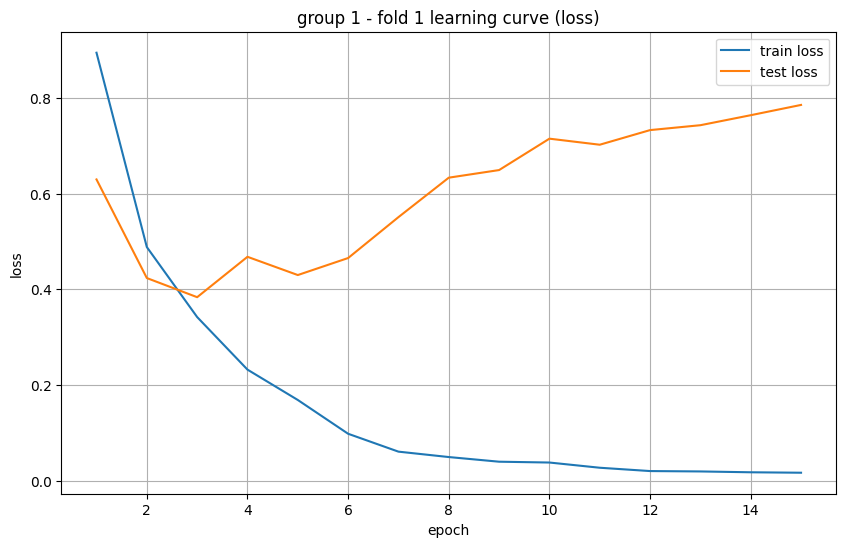

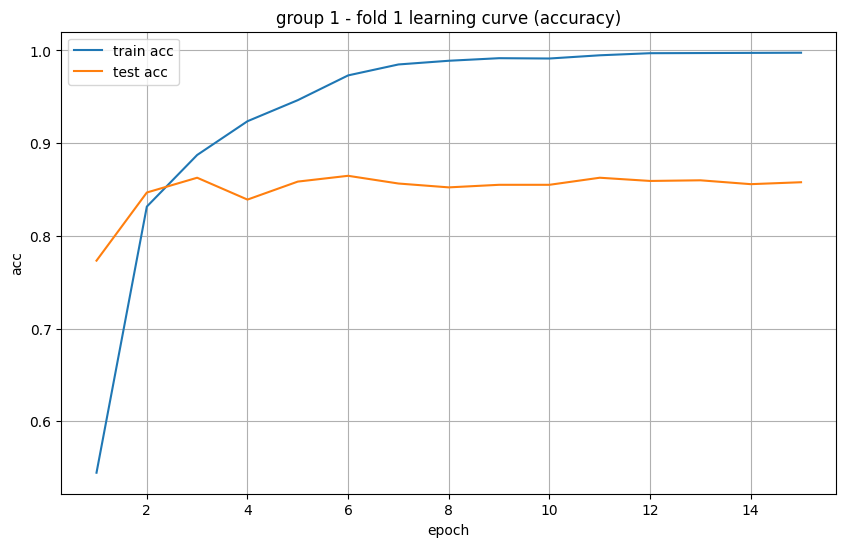

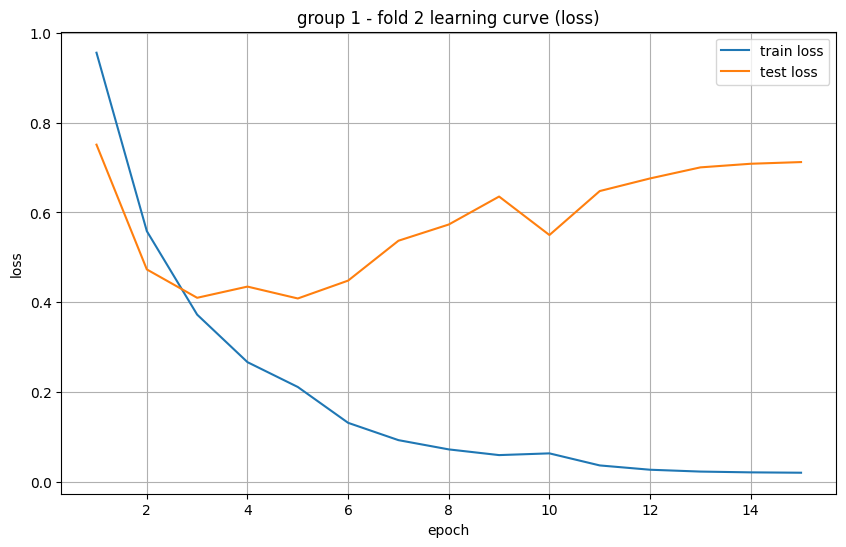

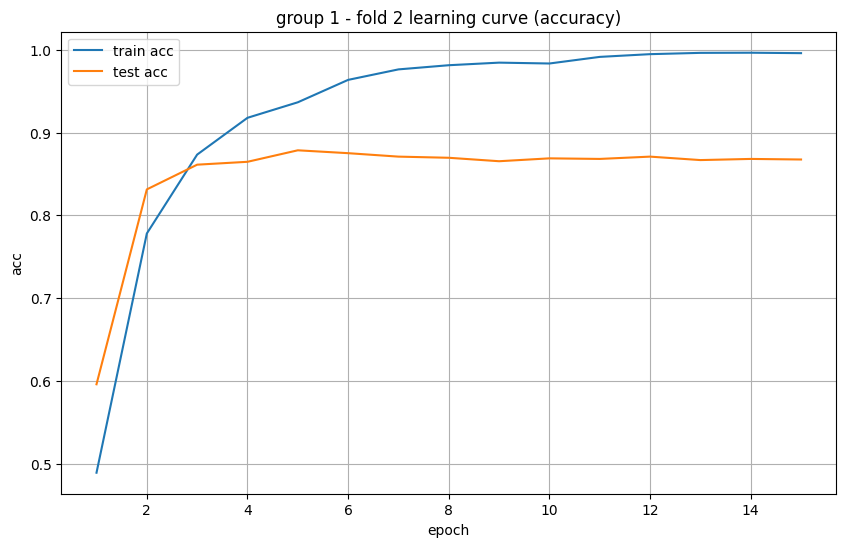

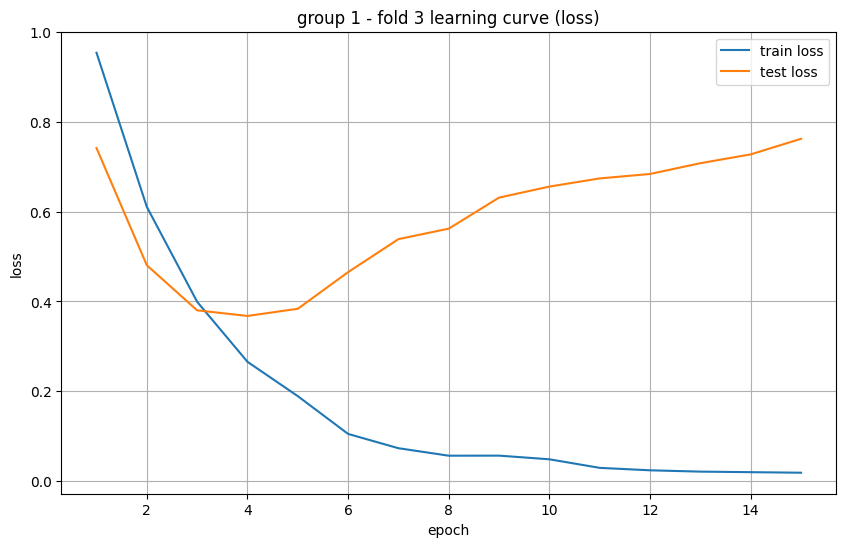

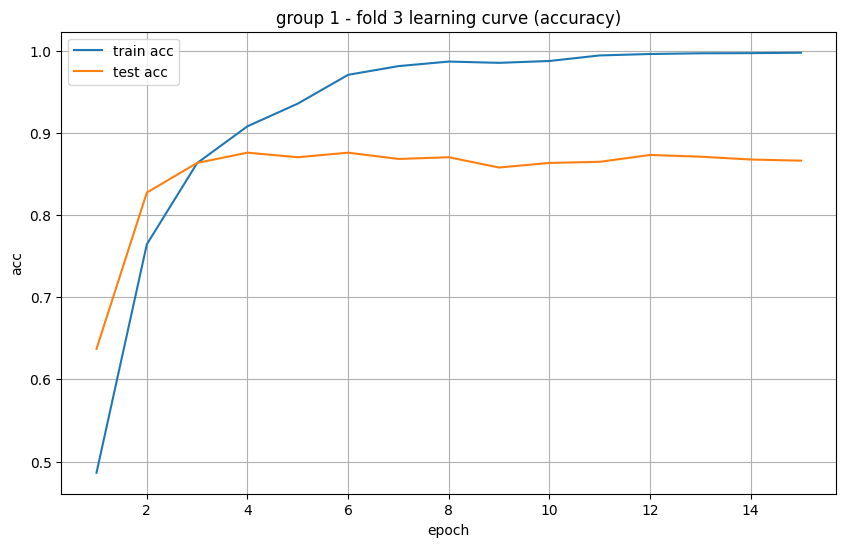

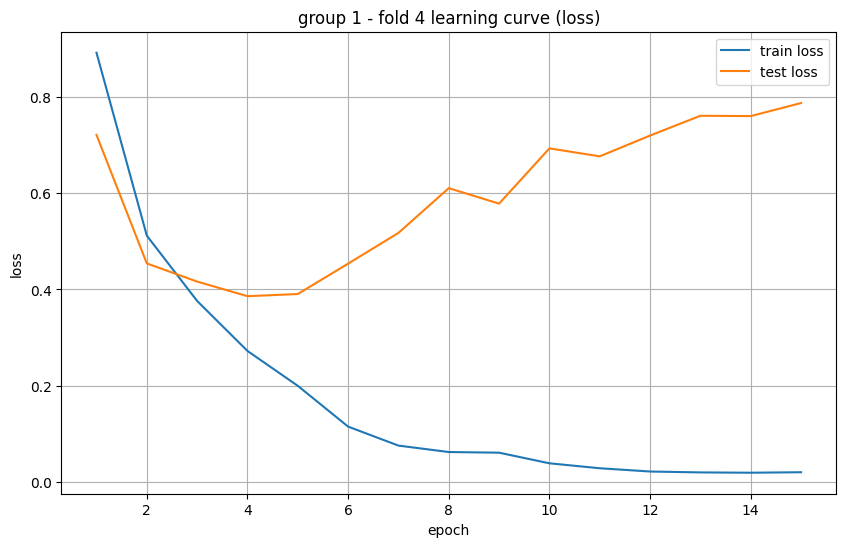

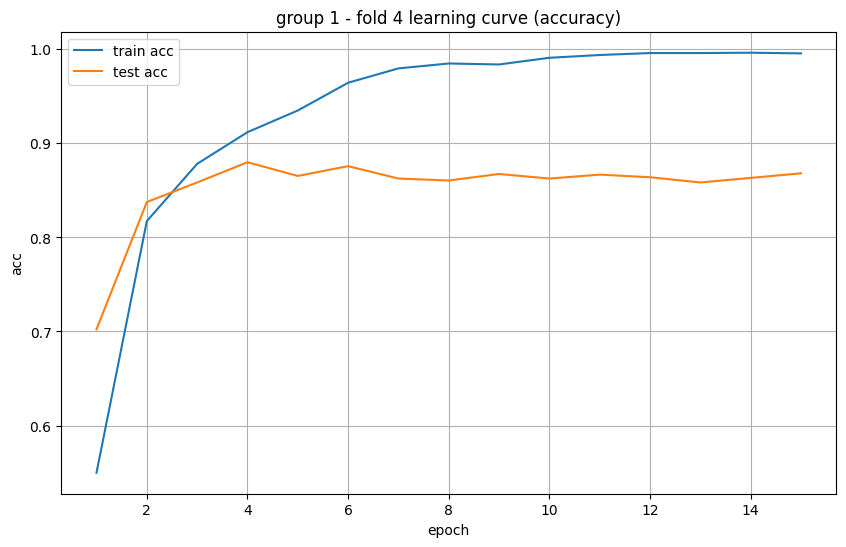

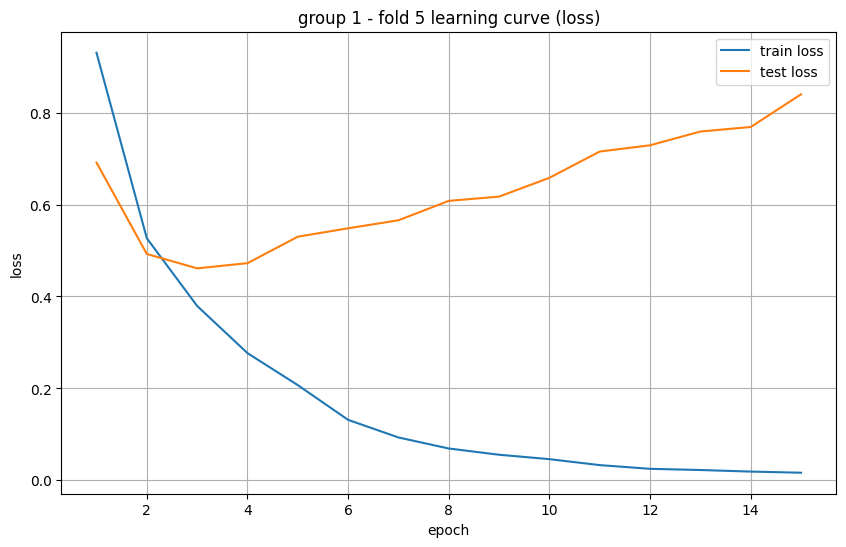

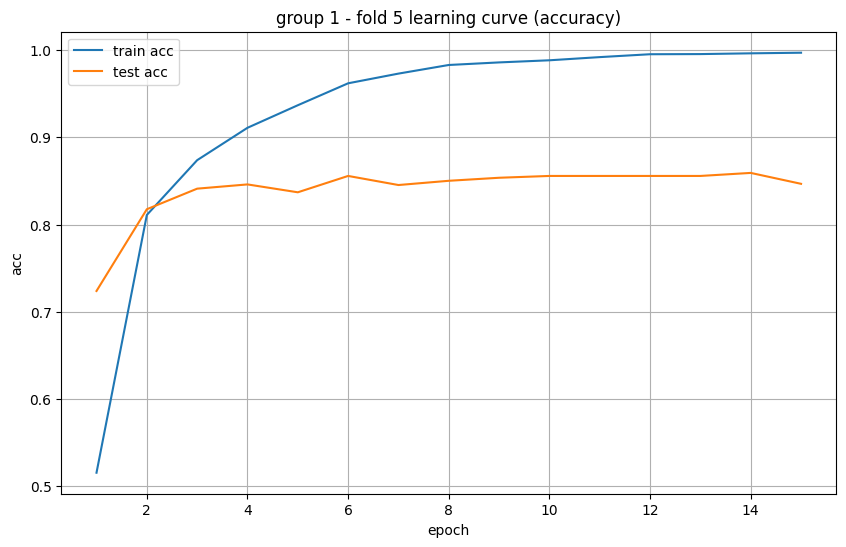

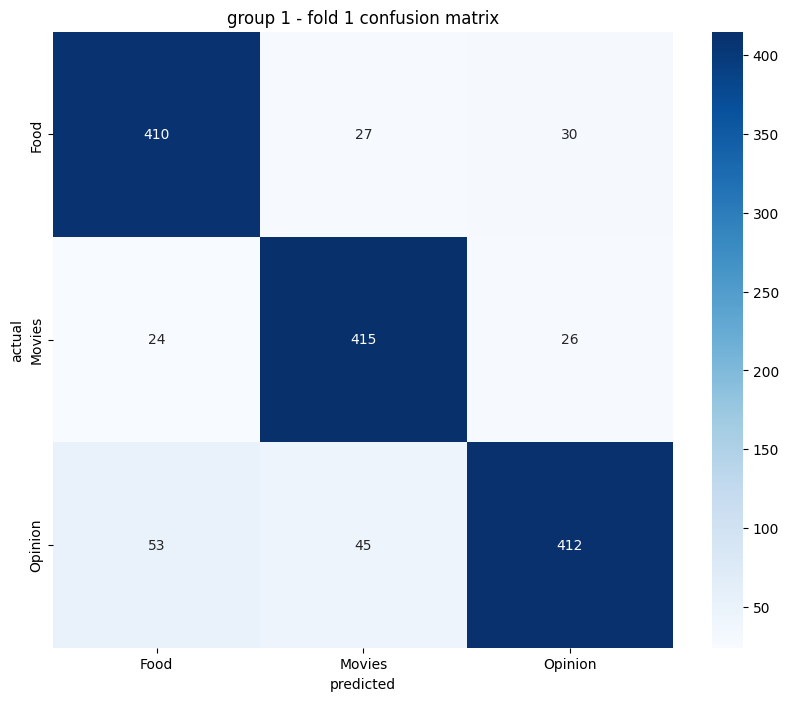

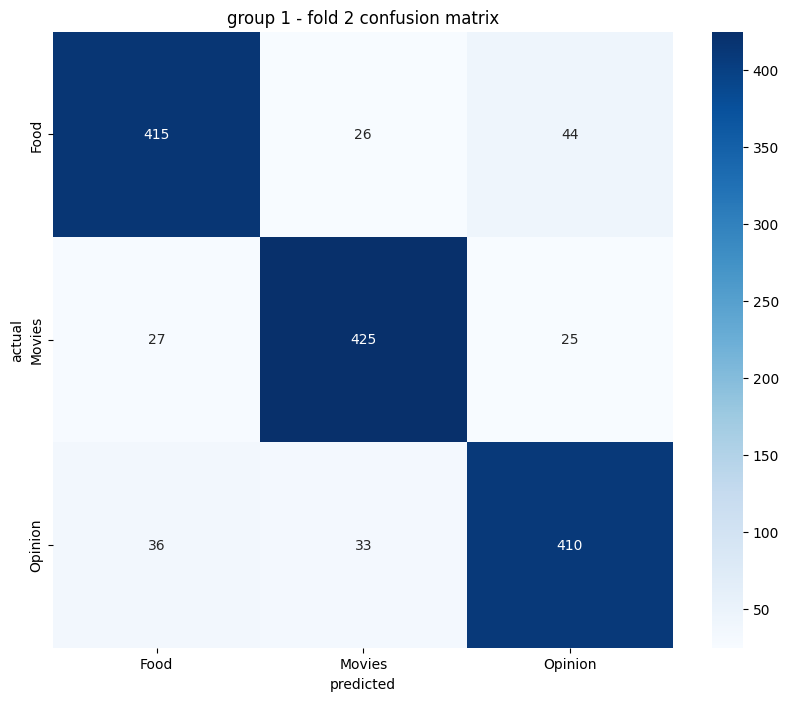

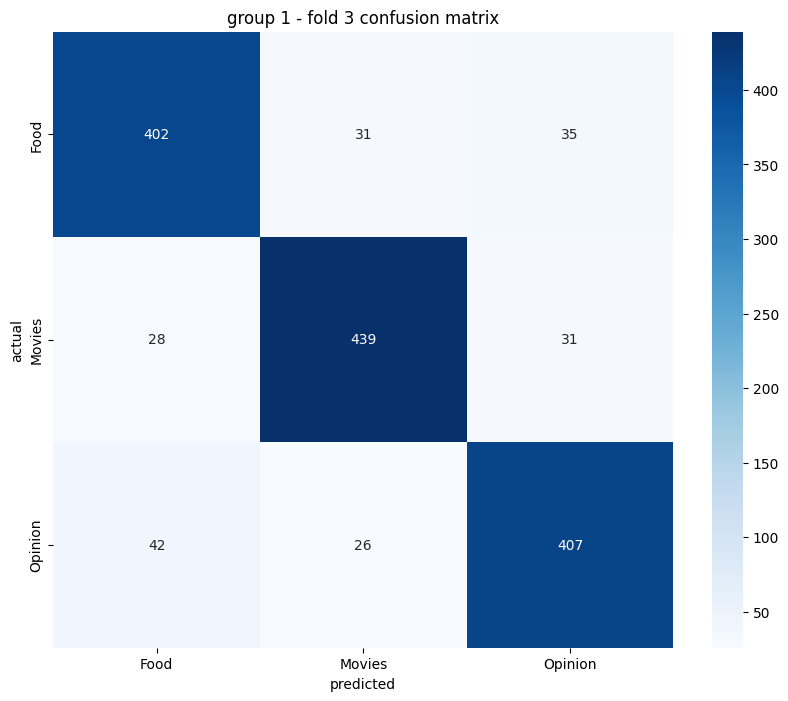

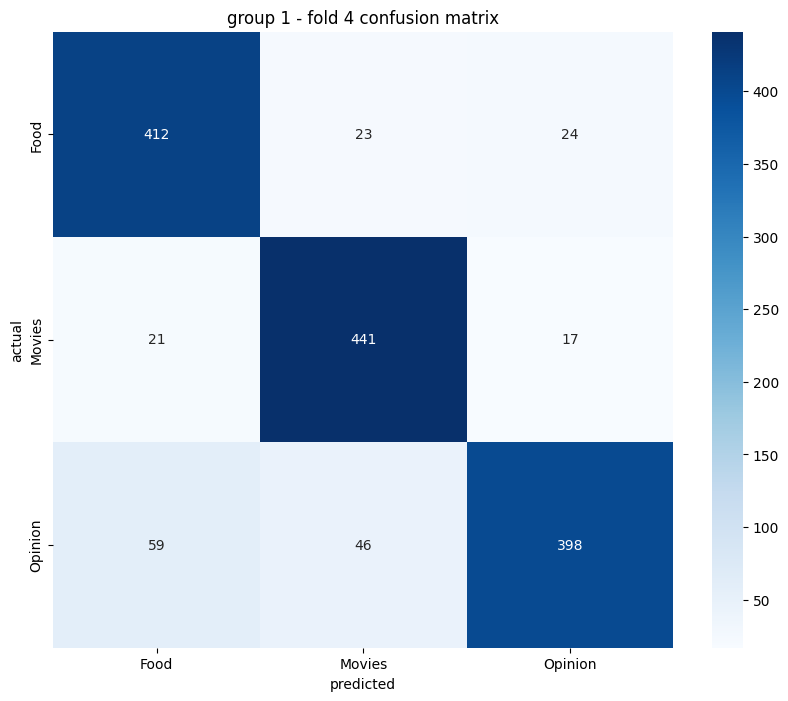

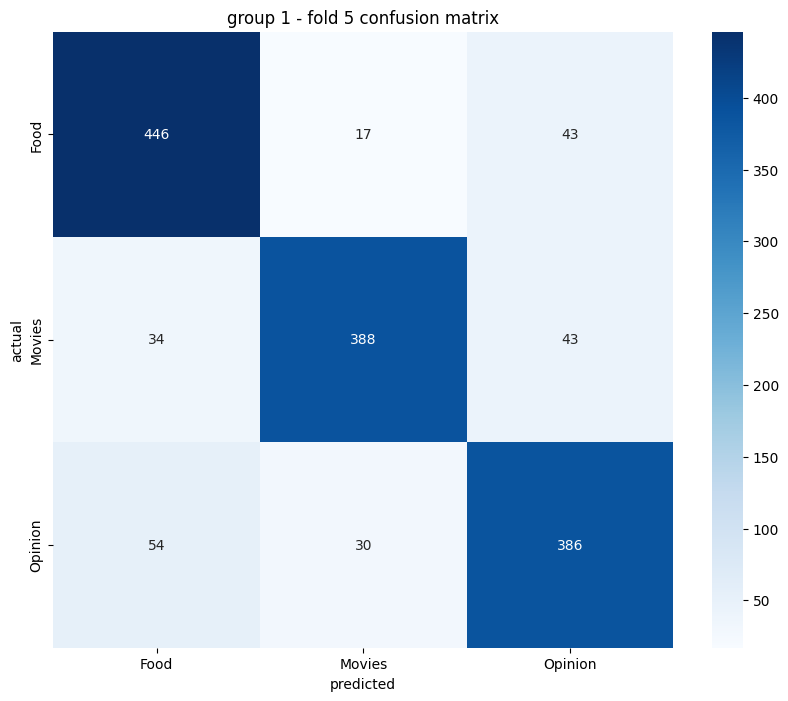


group 2 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0345, train acc: 0.4530
                               test loss: 0.9268, test acc: 0.5593
    epoch 5/15: train loss: 0.2579, train acc: 0.9103
                               test loss: 0.4883, test acc: 0.8272
    epoch 10/15: train loss: 0.0509, train acc: 0.9863
                               test loss: 0.8584, test acc: 0.8085
    epoch 15/15: train loss: 0.0133, train acc: 0.9979
                               test loss: 1.0811, test acc: 0.8043

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0195, train acc: 0.4660
                               test loss: 0.8411, test acc: 0.6468
    epoch 5/15: train loss: 0.2462, train acc: 0.9177
                               test loss: 0.6401, test acc: 0.7946
    epoch 10/15: train loss: 0.0513, train acc: 0.9868
                               test loss: 0.8738, test acc: 0.7974
    epoch 15/15: train loss: 0.0188, train acc: 0.9970
                               test lo

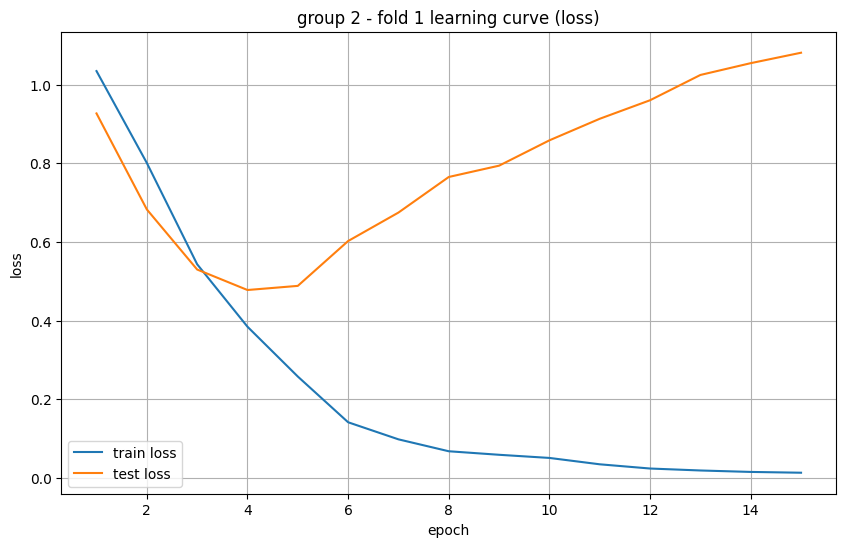

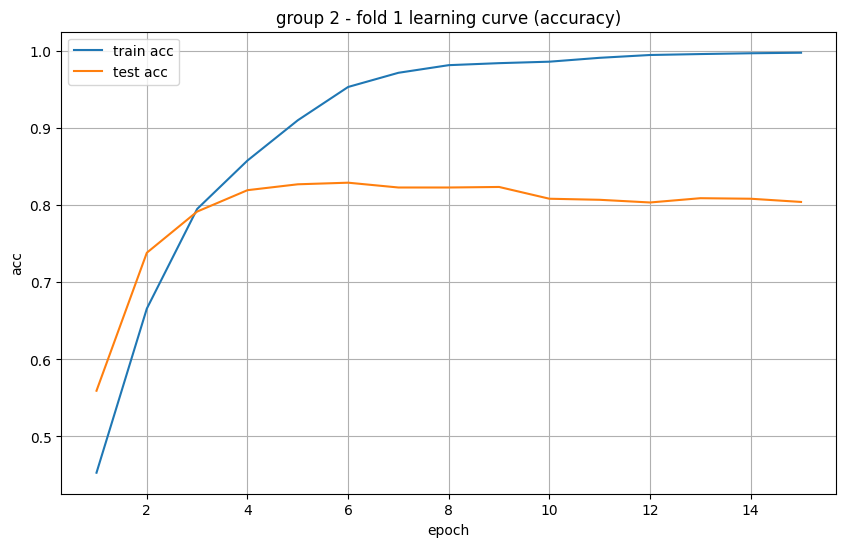

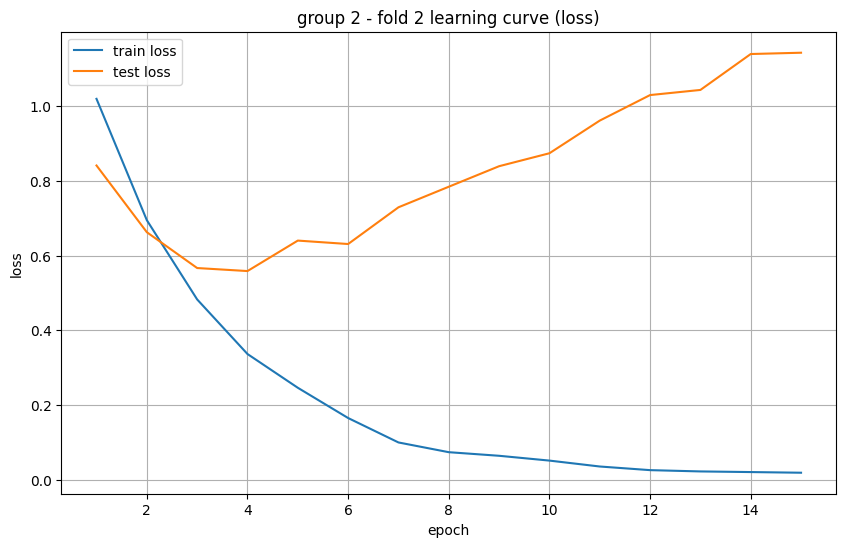

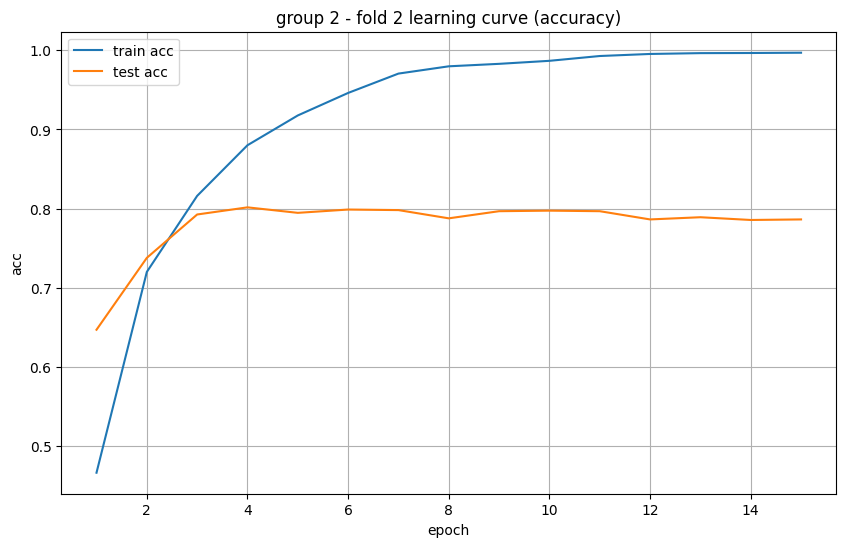

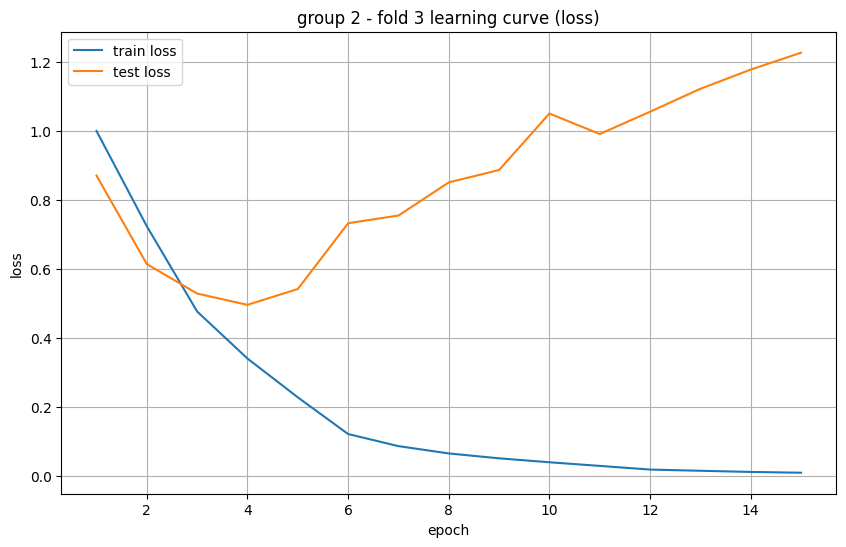

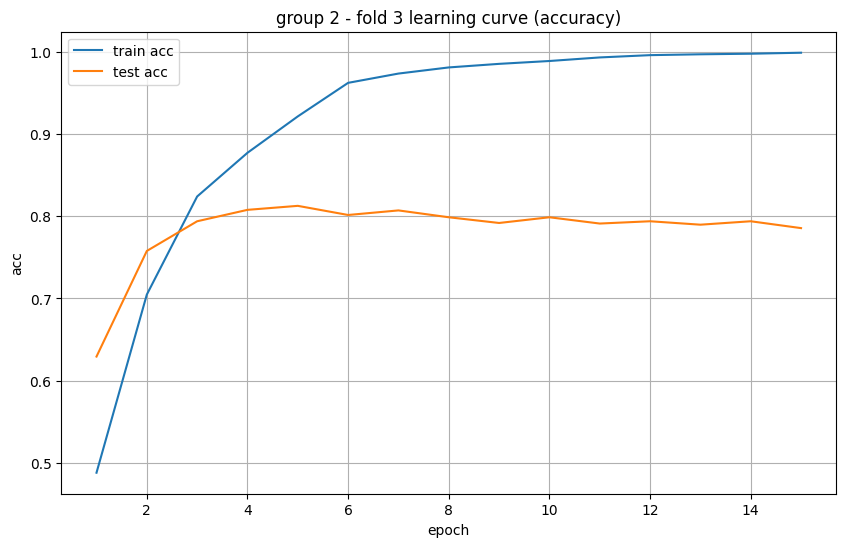

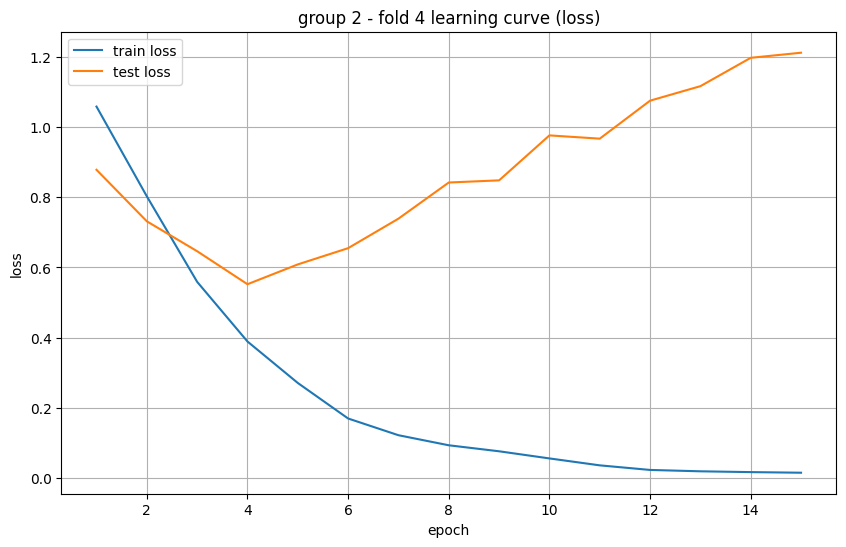

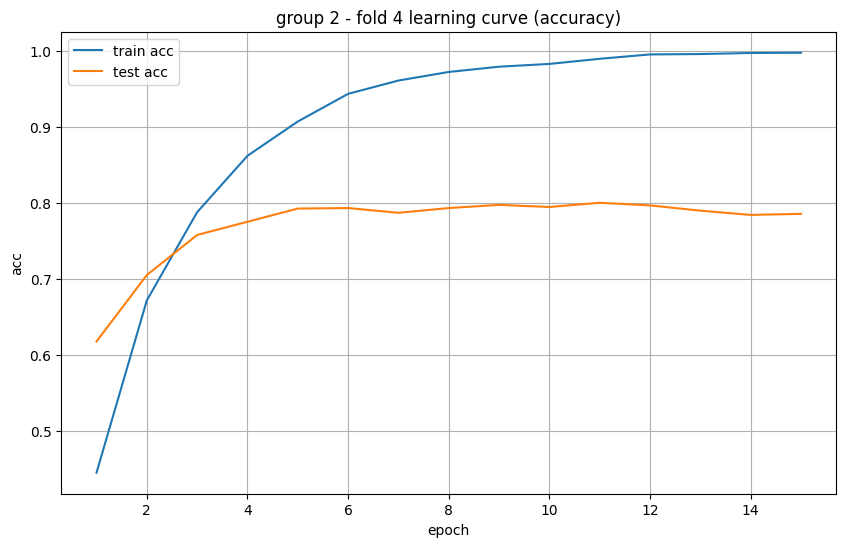

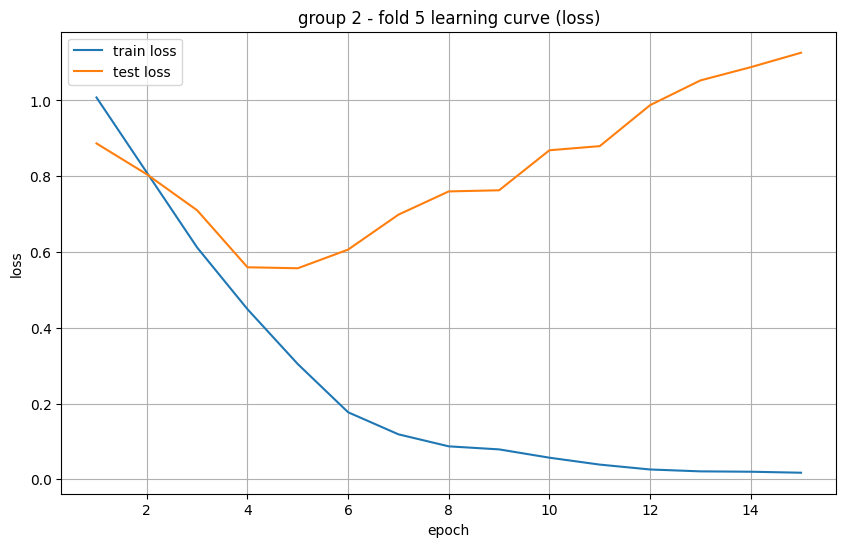

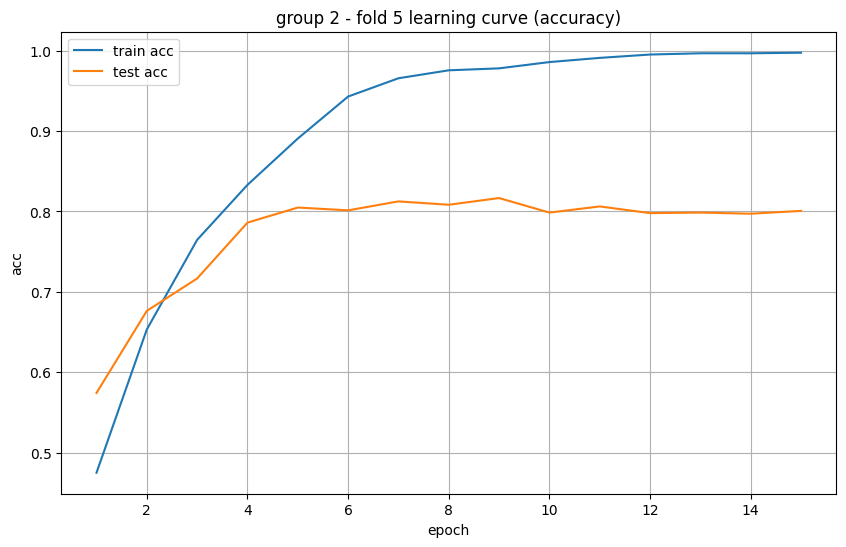

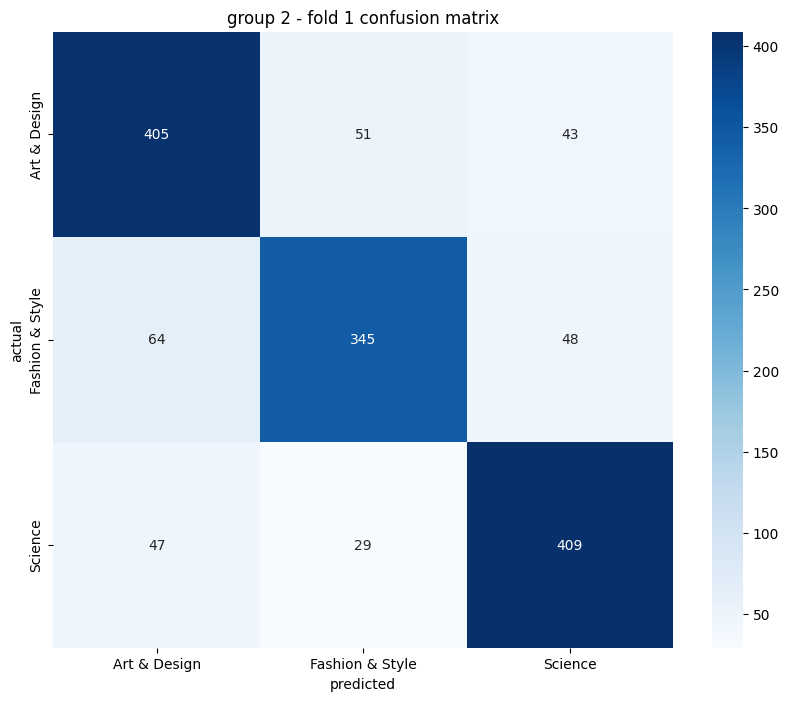

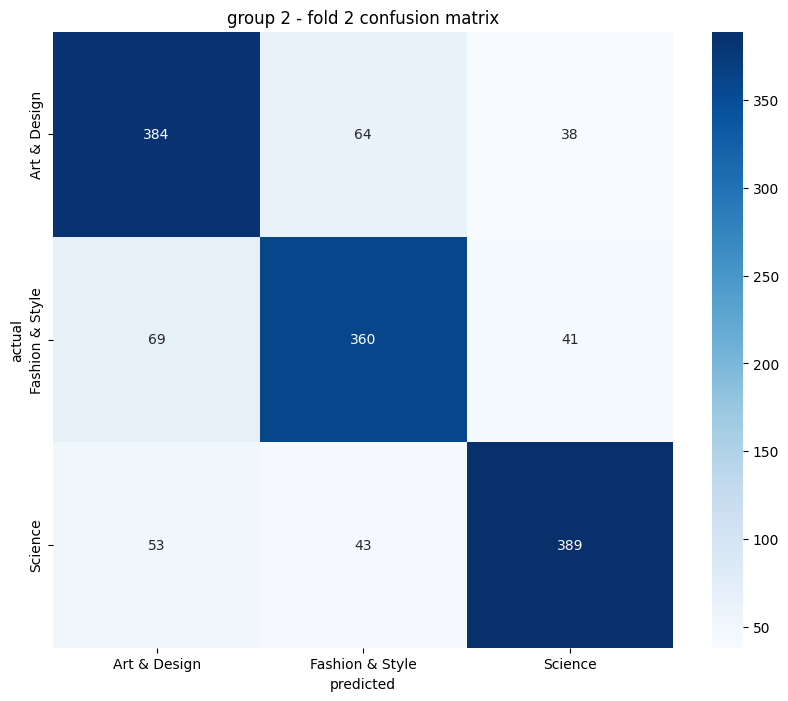

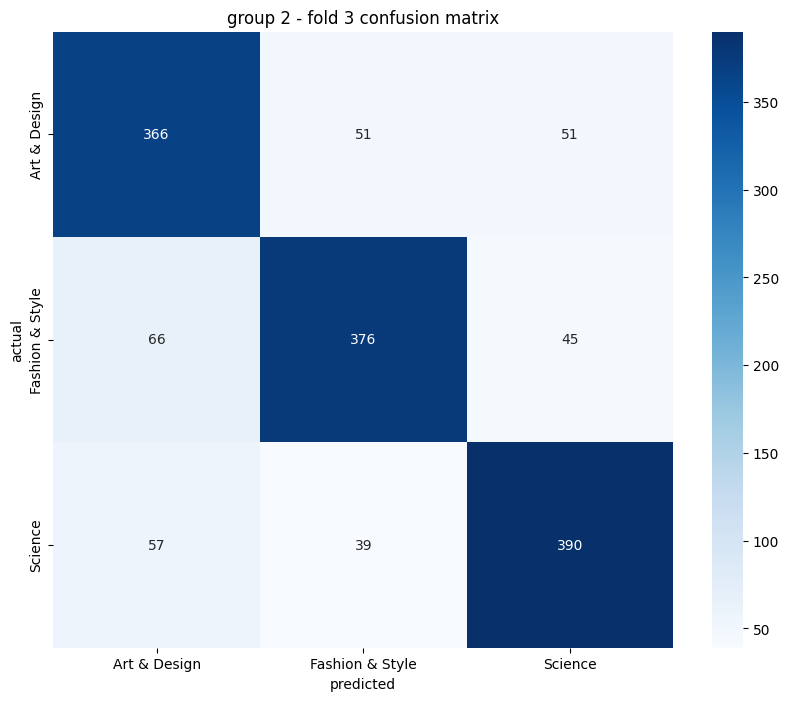

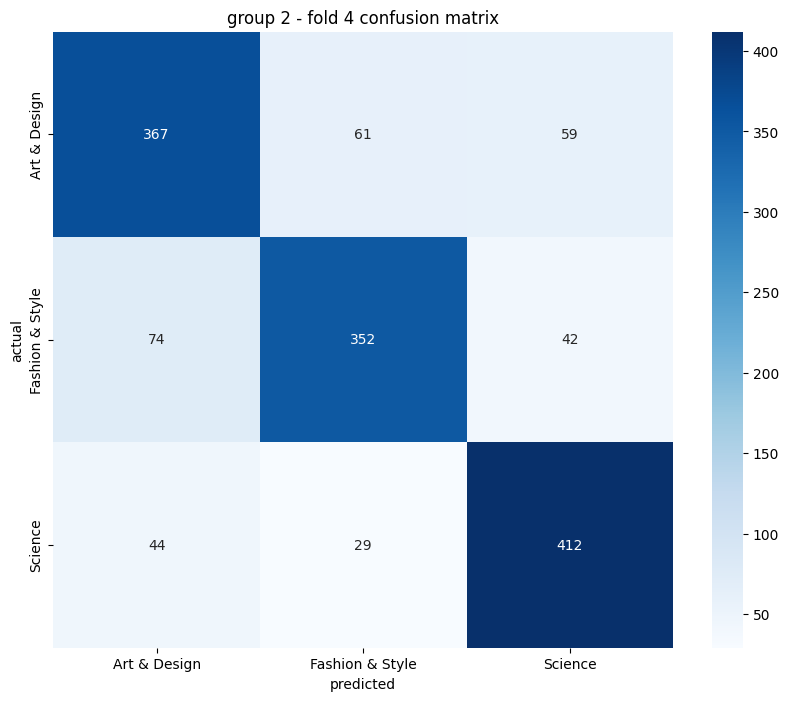

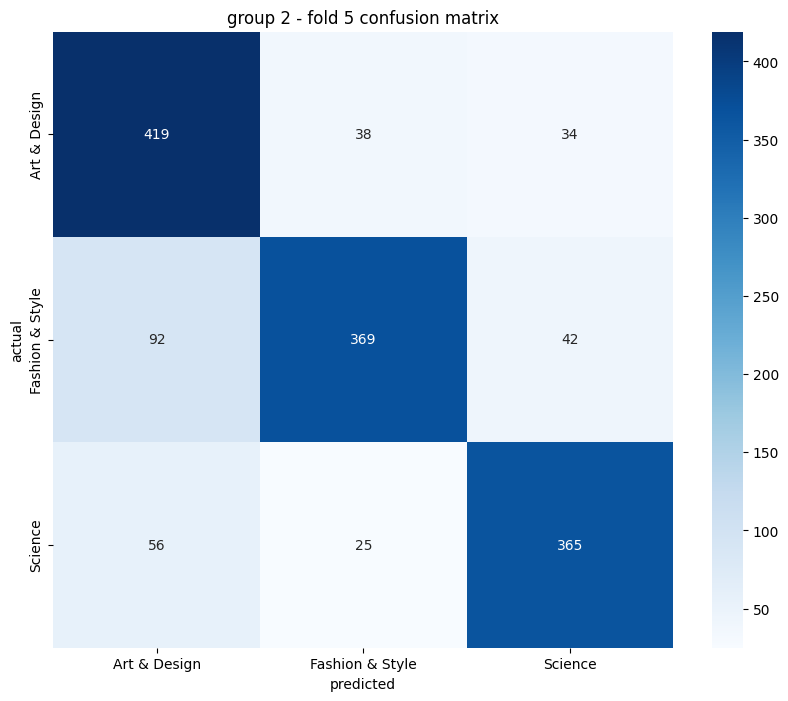


group 3 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.9600, train acc: 0.5233
                               test loss: 0.8029, test acc: 0.6667
    epoch 5/15: train loss: 0.3231, train acc: 0.8876
                               test loss: 0.5331, test acc: 0.8229
    epoch 10/15: train loss: 0.0625, train acc: 0.9824
                               test loss: 0.8015, test acc: 0.8079
    epoch 15/15: train loss: 0.0146, train acc: 0.9978
                               test loss: 1.0029, test acc: 0.8165

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.9605, train acc: 0.5143
                               test loss: 0.7571, test acc: 0.7075
    epoch 5/15: train loss: 0.2591, train acc: 0.9118
                               test loss: 0.4775, test acc: 0.8394
    epoch 10/15: train loss: 0.0638, train acc: 0.9849
                               test loss: 0.7674, test acc: 0.8208
    epoch 15/15: train loss: 0.0219, train acc: 0.9964
                               test lo

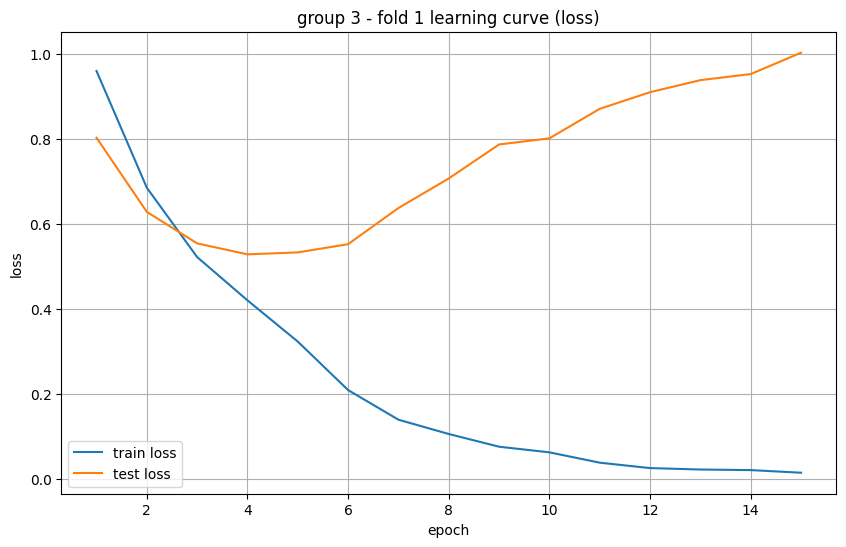

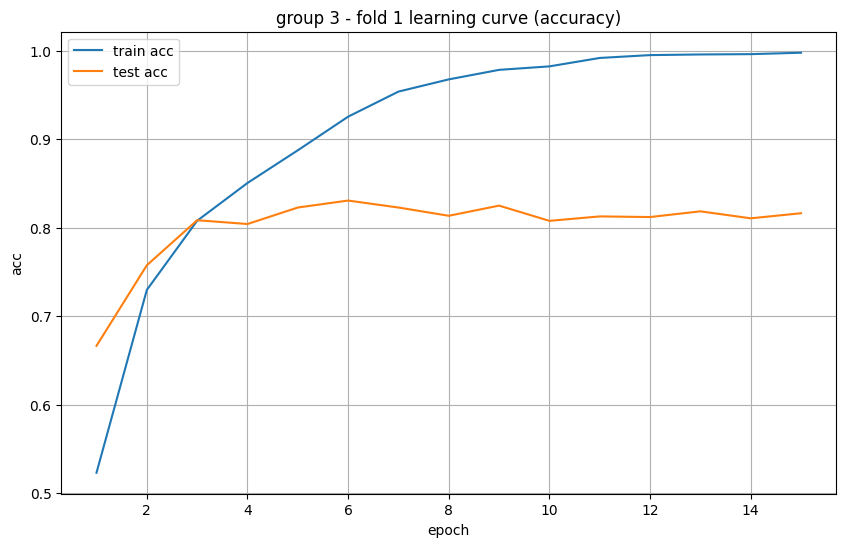

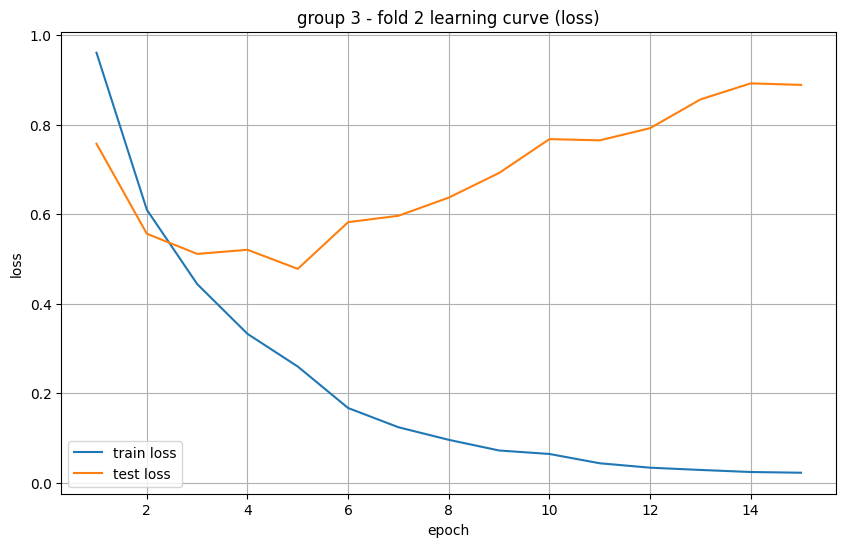

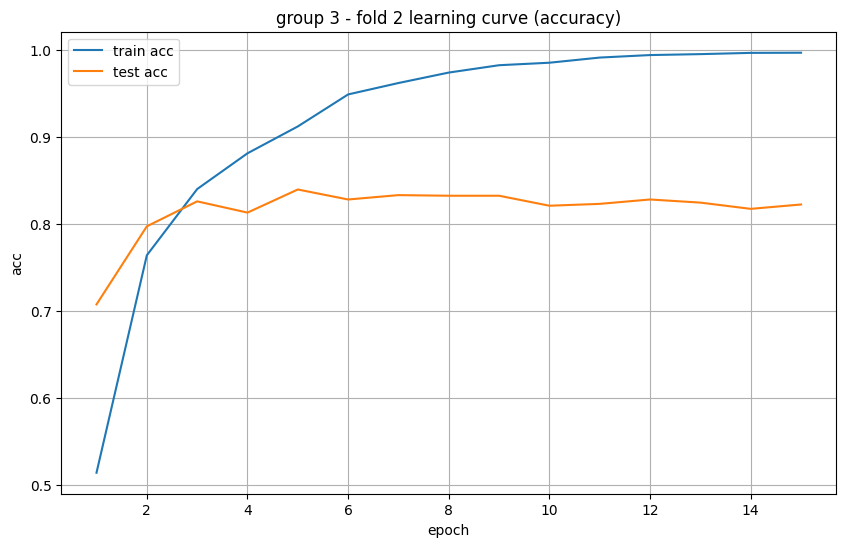

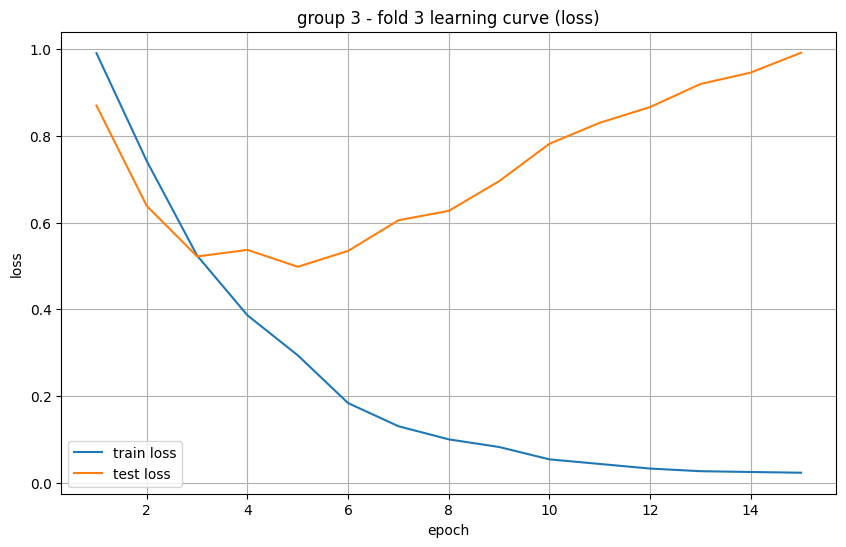

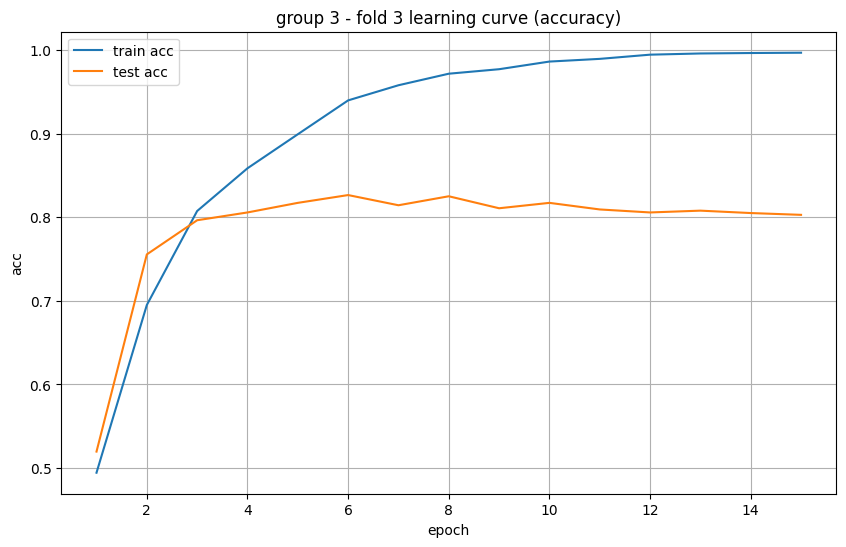

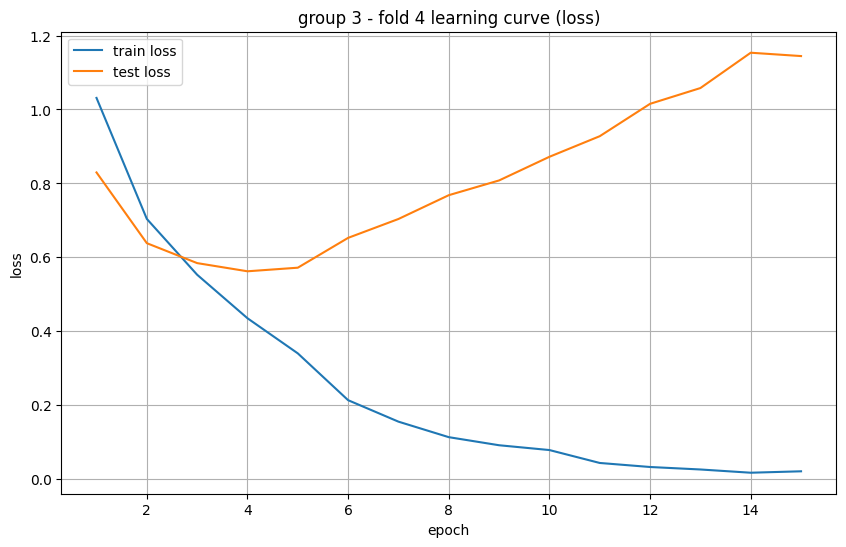

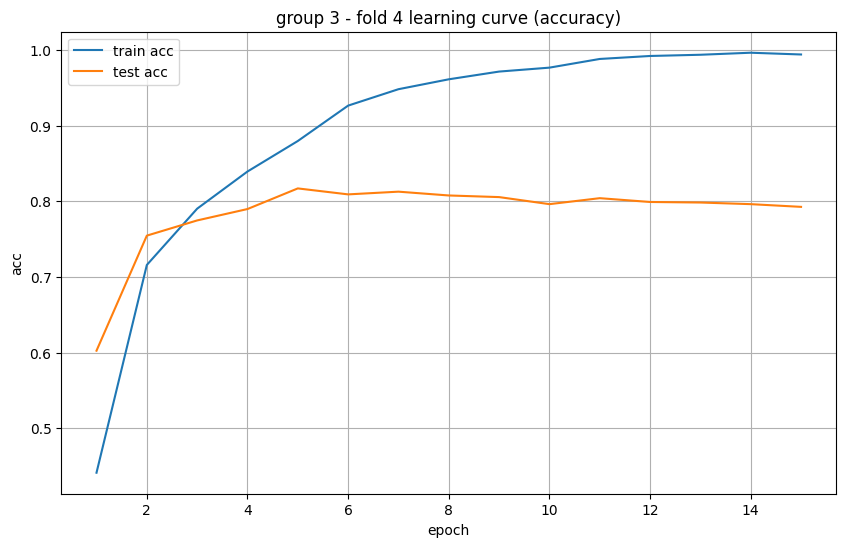

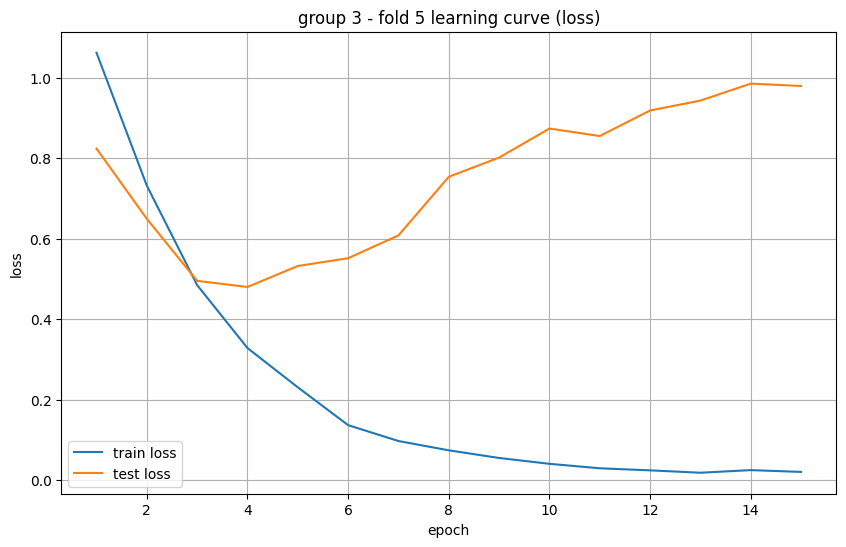

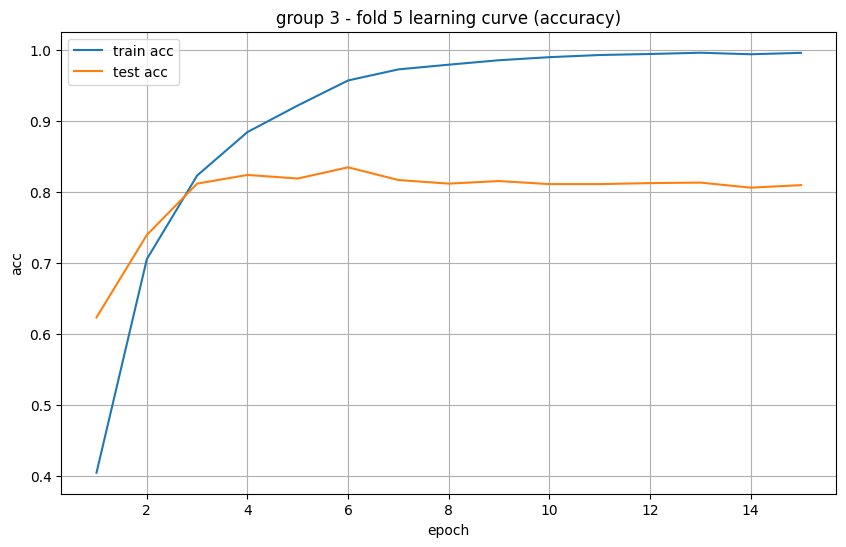

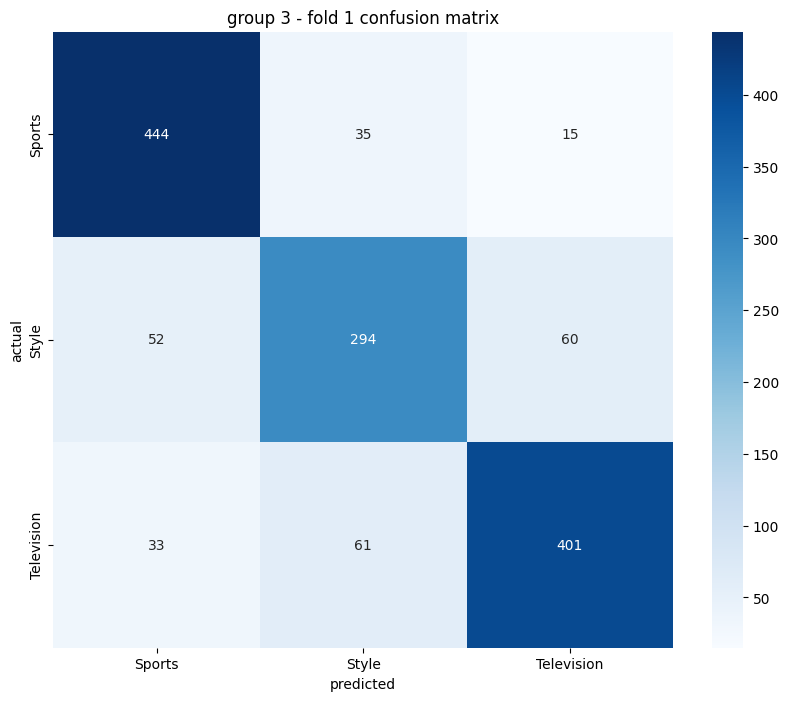

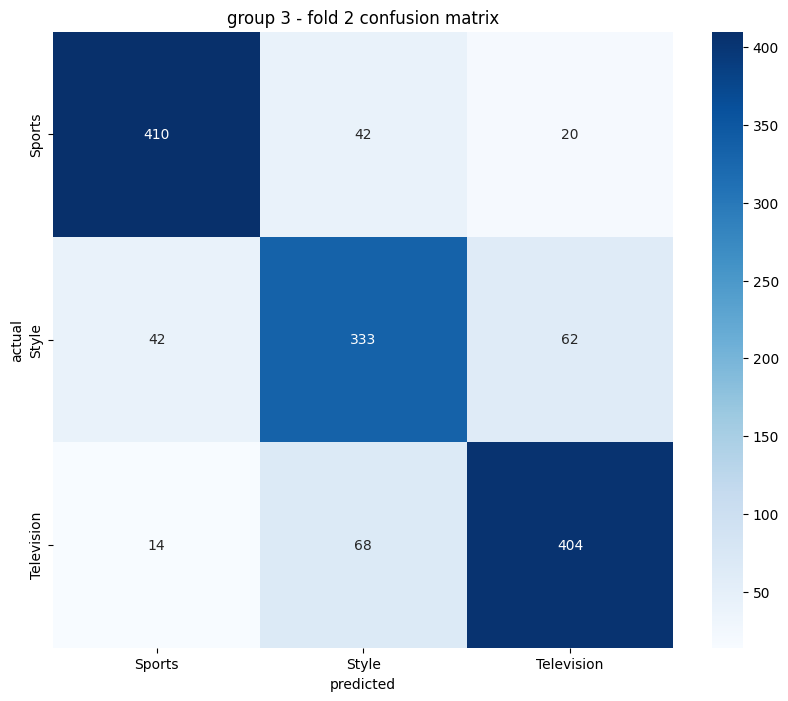

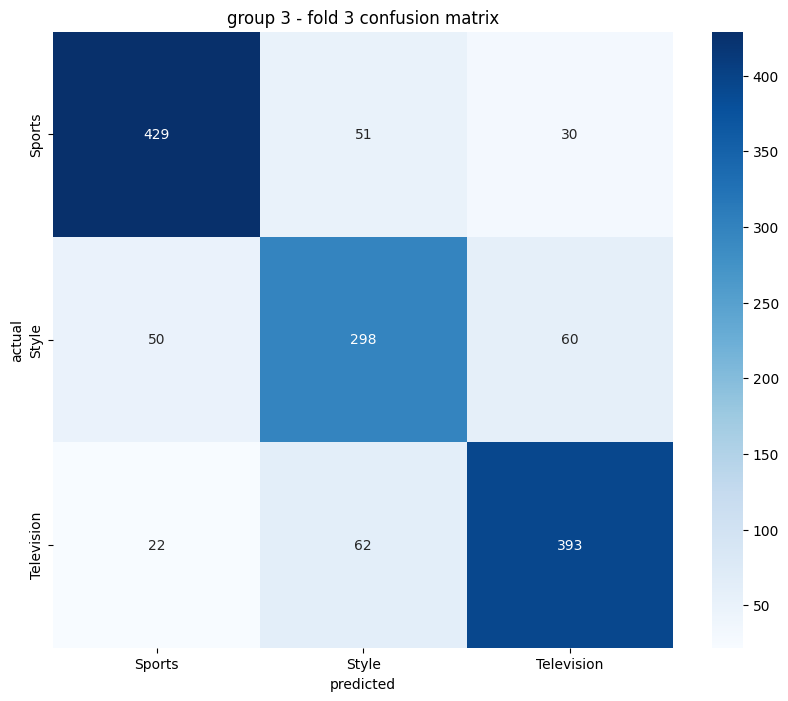

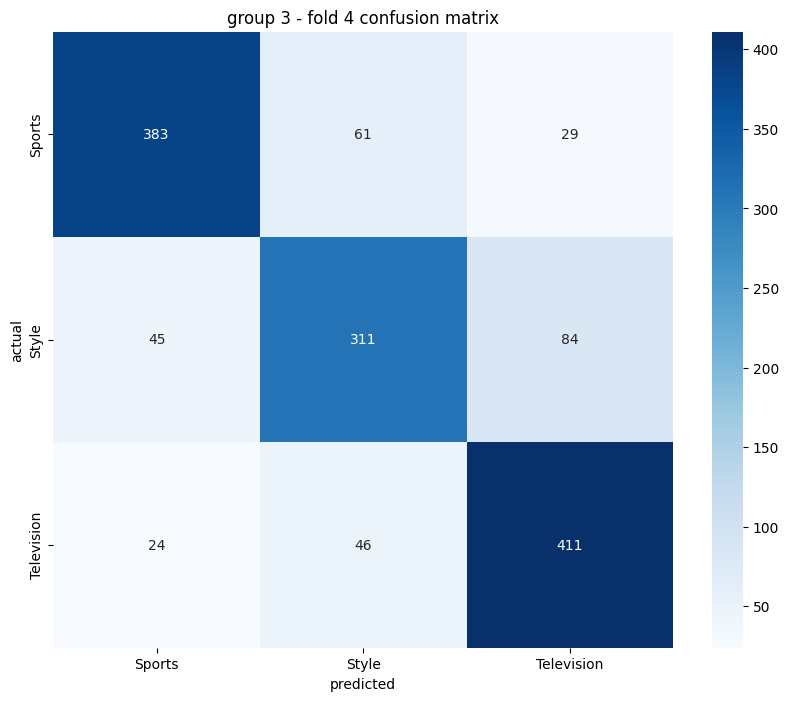

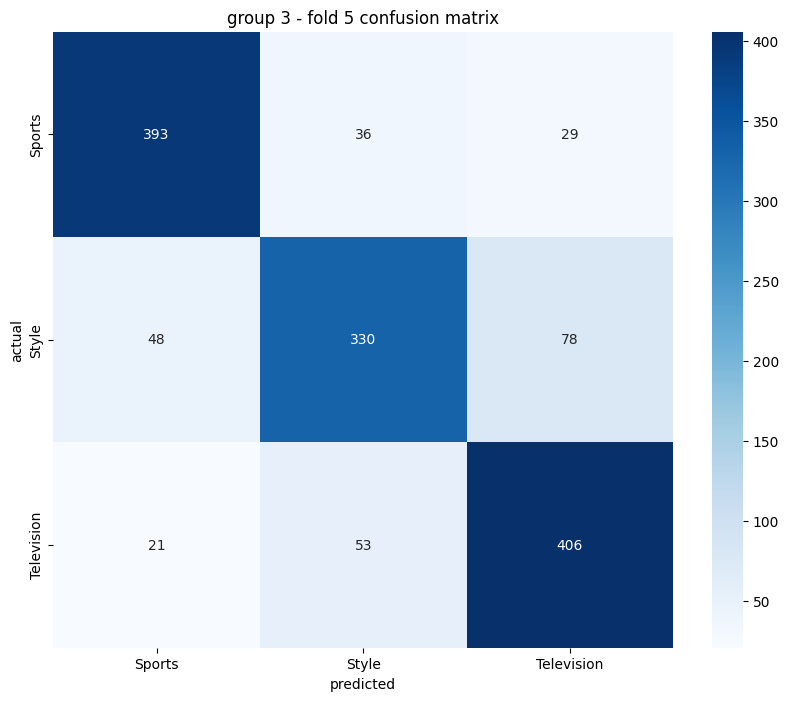


group 4 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0559, train acc: 0.4285
                               test loss: 0.8211, test acc: 0.6398
    epoch 5/15: train loss: 0.1468, train acc: 0.9513
                               test loss: 0.3762, test acc: 0.8762
    epoch 10/15: train loss: 0.0288, train acc: 0.9929
                               test loss: 0.6018, test acc: 0.8693
    epoch 15/15: train loss: 0.0111, train acc: 0.9981
                               test loss: 0.7360, test acc: 0.8693

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0251, train acc: 0.4555
                               test loss: 0.6915, test acc: 0.6829
    epoch 5/15: train loss: 0.1313, train acc: 0.9557
                               test loss: 0.4262, test acc: 0.8776
    epoch 10/15: train loss: 0.0205, train acc: 0.9946
                               test loss: 0.5940, test acc: 0.8776
    epoch 15/15: train loss: 0.0026, train acc: 0.9997
                               test lo

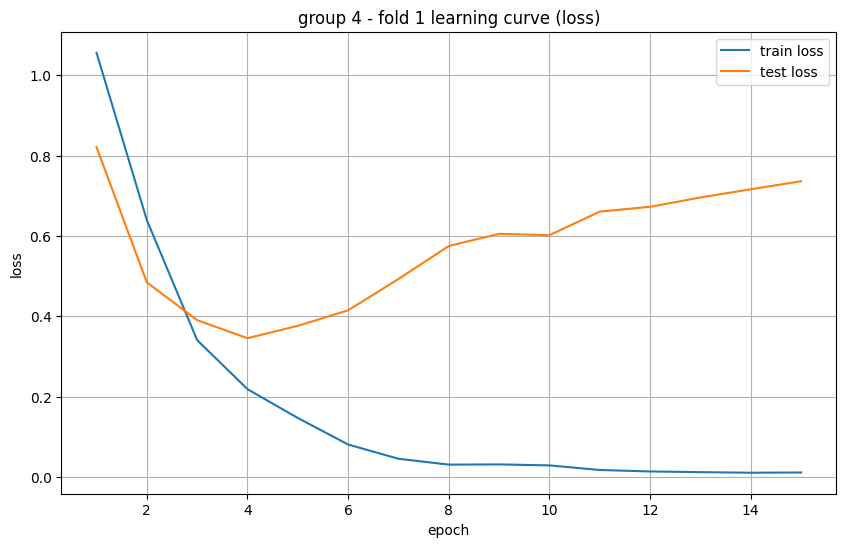

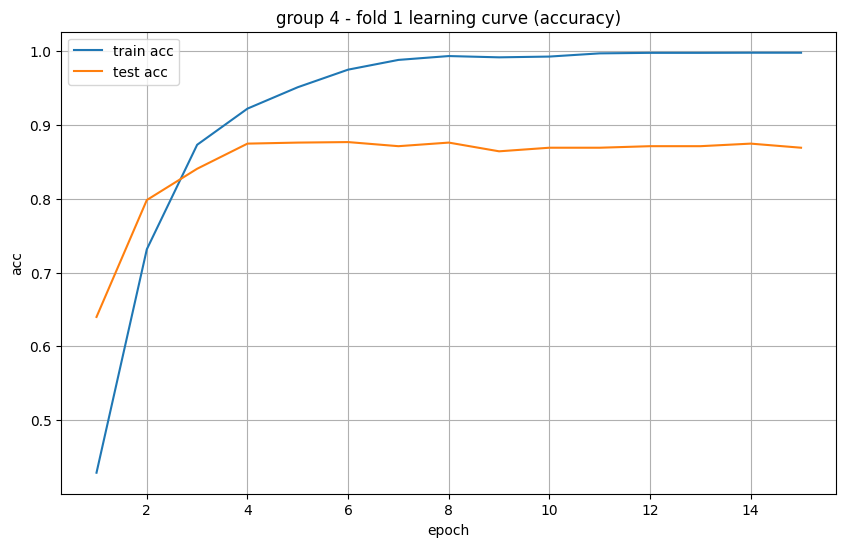

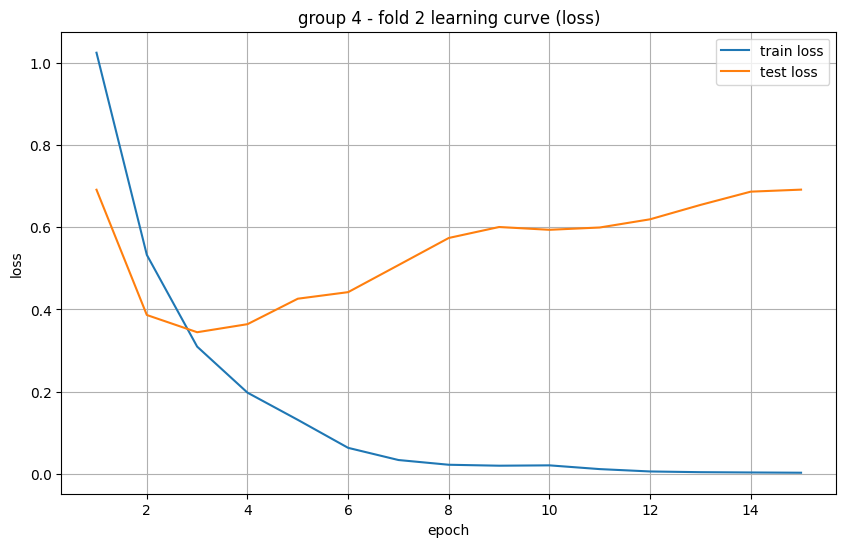

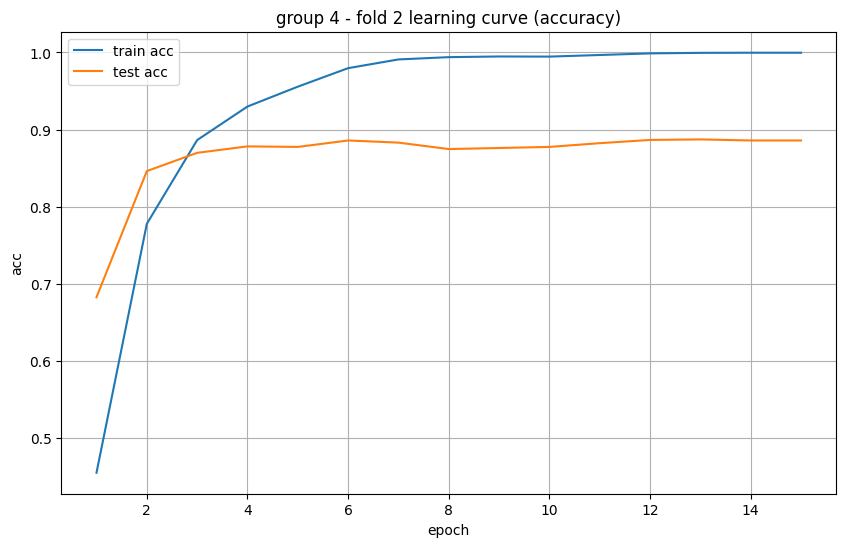

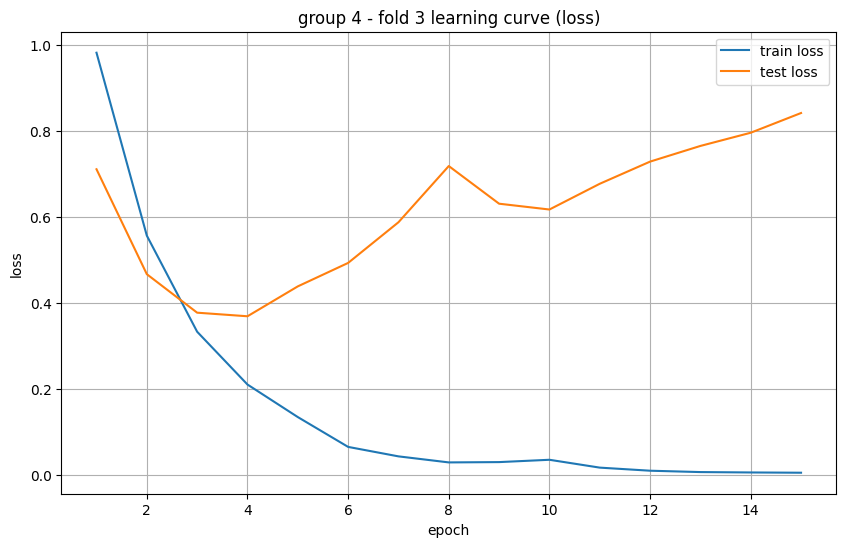

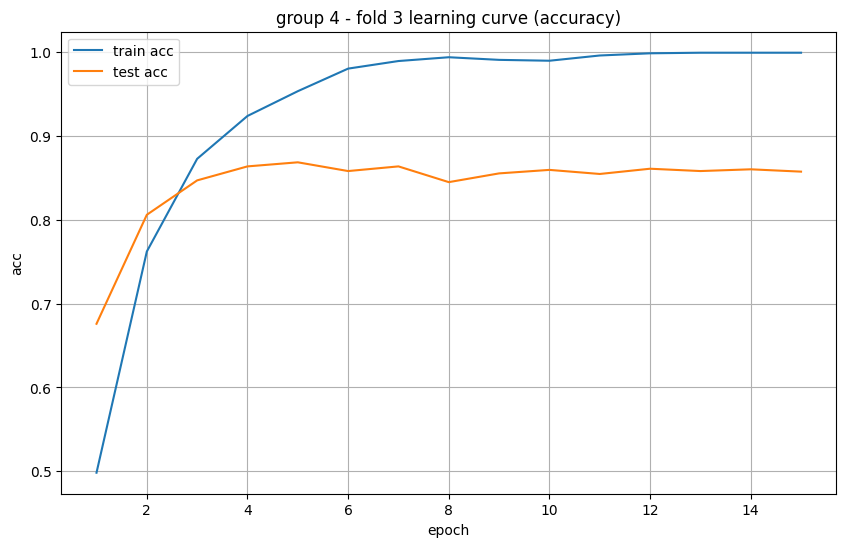

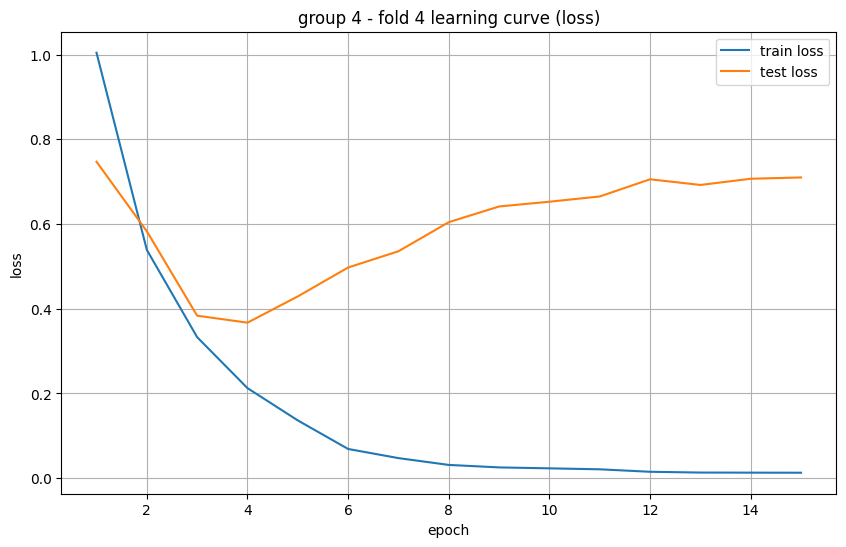

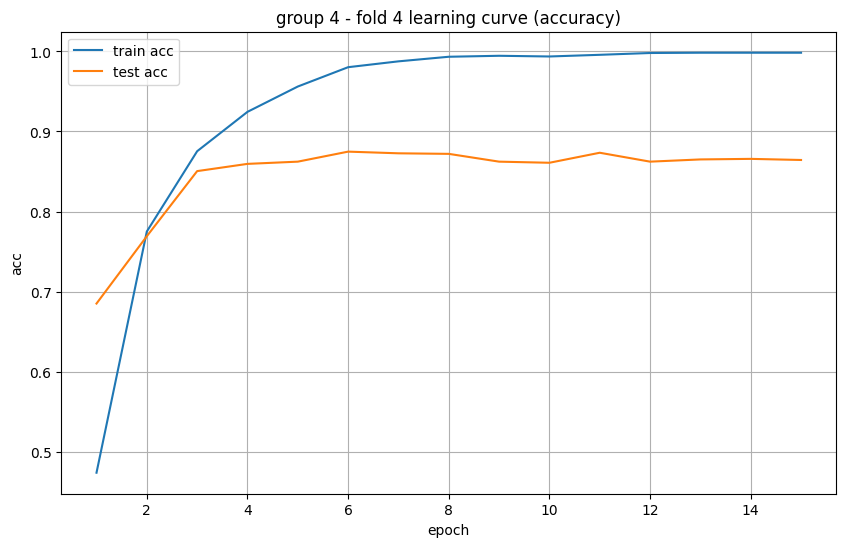

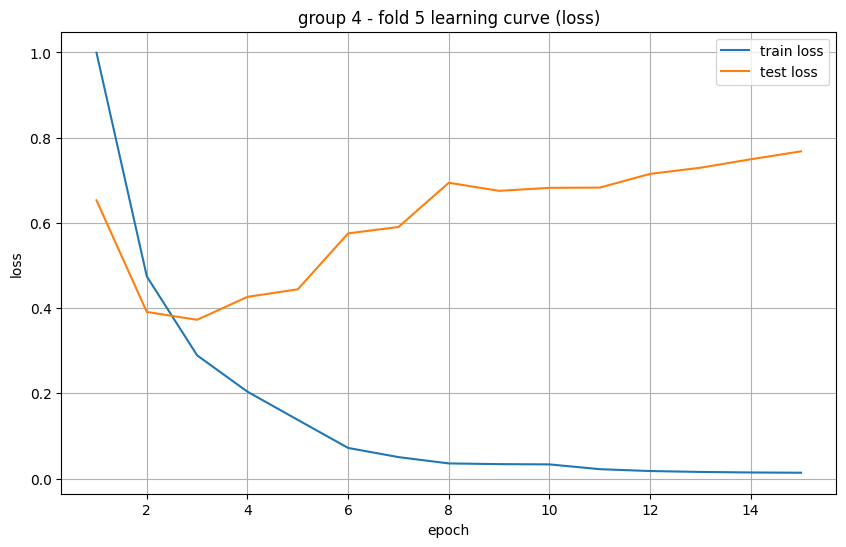

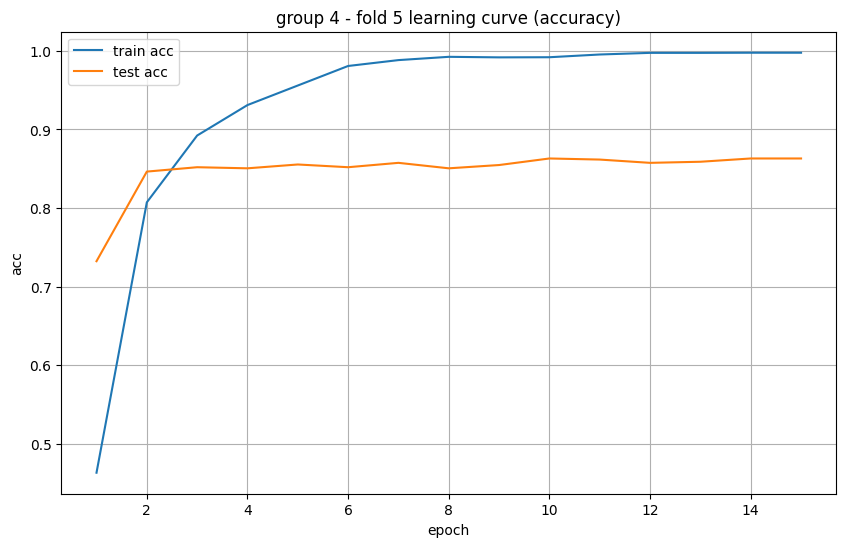

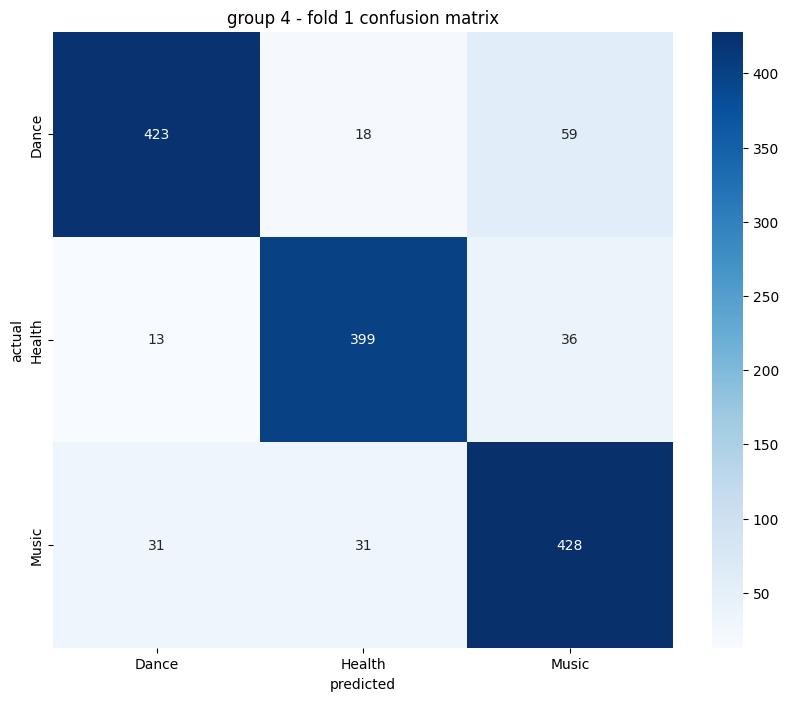

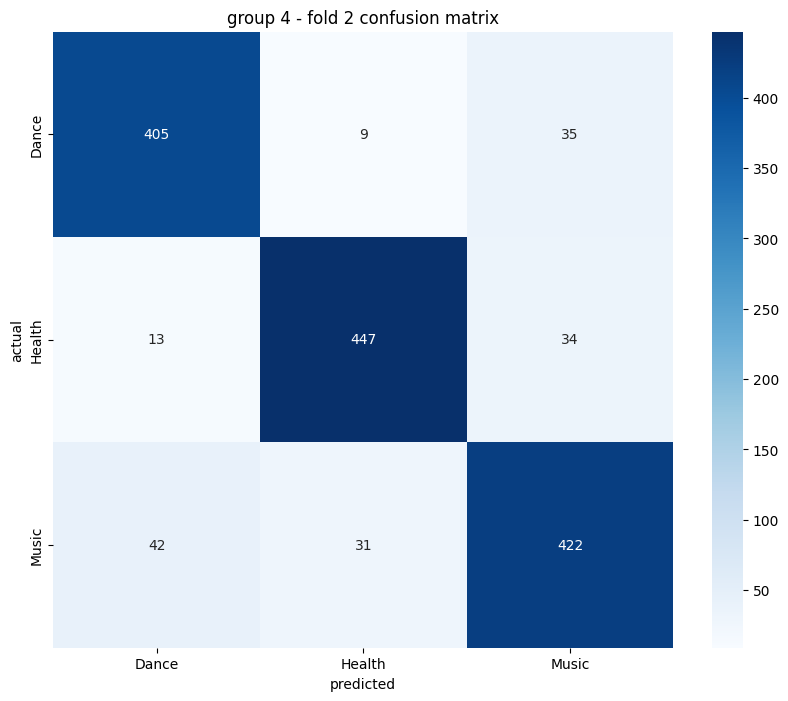

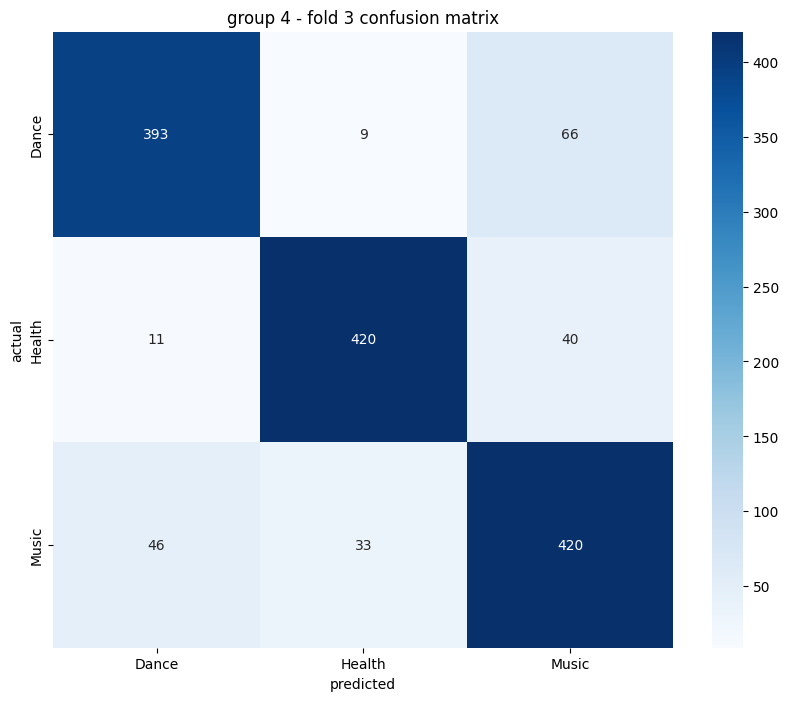

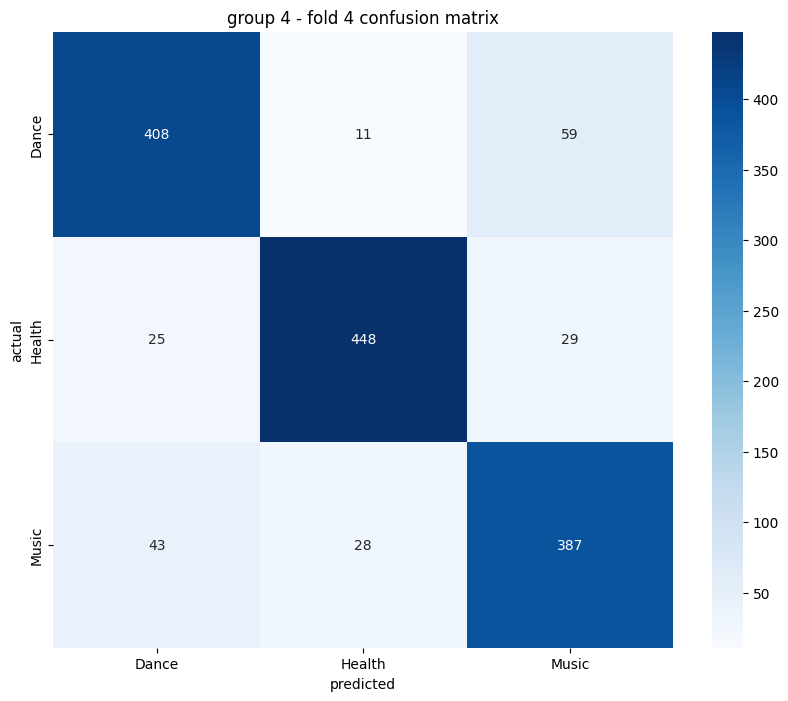

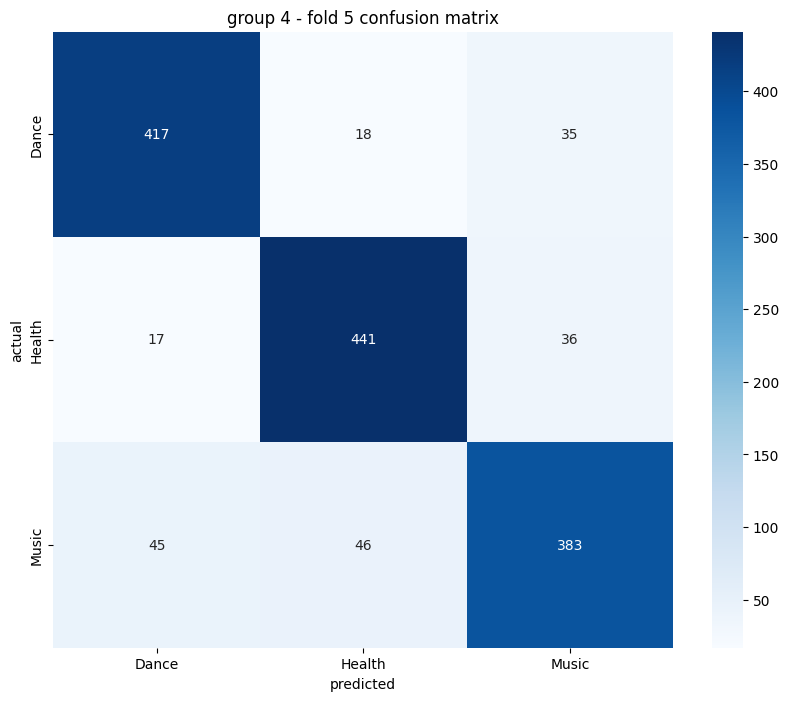


group 5 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0771, train acc: 0.4139
                               test loss: 0.8678, test acc: 0.5904
    epoch 5/15: train loss: 0.2672, train acc: 0.9077
                               test loss: 0.5410, test acc: 0.7969
    epoch 10/15: train loss: 0.0535, train acc: 0.9873
                               test loss: 0.8956, test acc: 0.8004
    epoch 15/15: train loss: 0.0167, train acc: 0.9967
                               test loss: 1.1857, test acc: 0.7949

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0703, train acc: 0.4127
                               test loss: 0.9648, test acc: 0.5063
    epoch 5/15: train loss: 0.2678, train acc: 0.9123
                               test loss: 0.6116, test acc: 0.8046
    epoch 10/15: train loss: 0.0563, train acc: 0.9866
                               test loss: 1.0820, test acc: 0.7754
    epoch 15/15: train loss: 0.0209, train acc: 0.9957
                               test lo

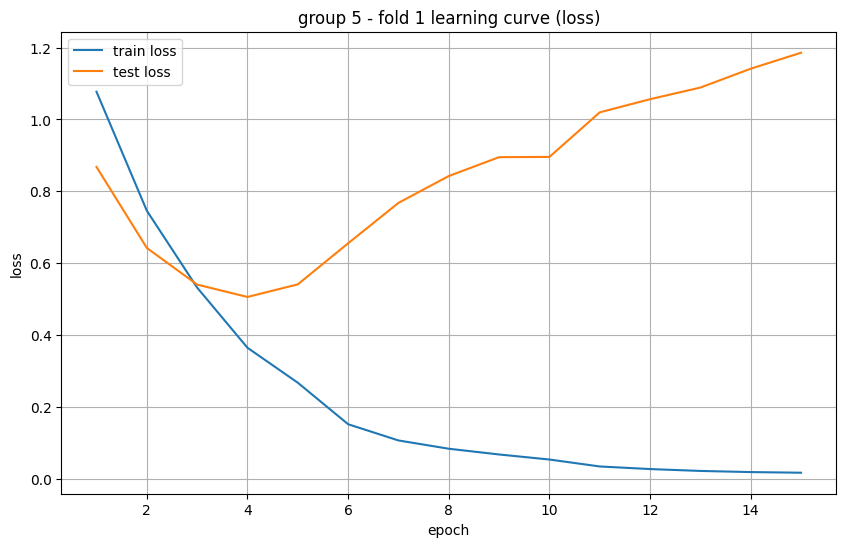

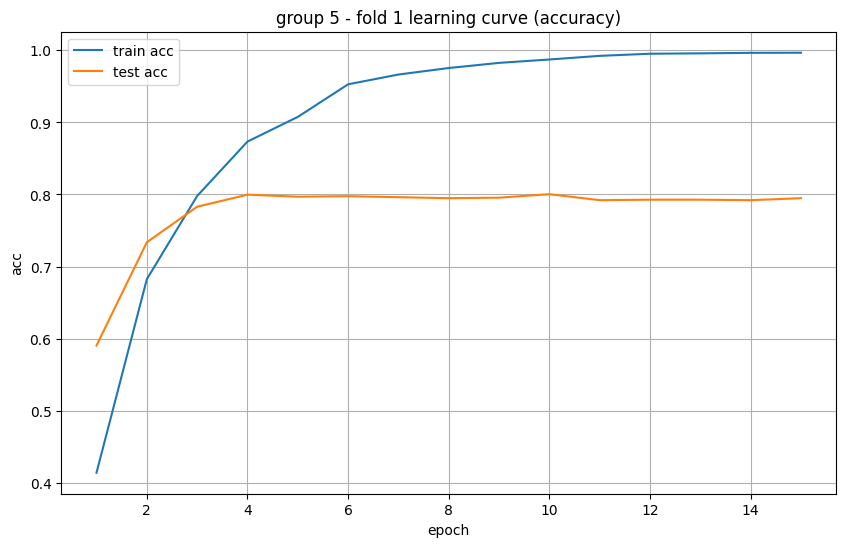

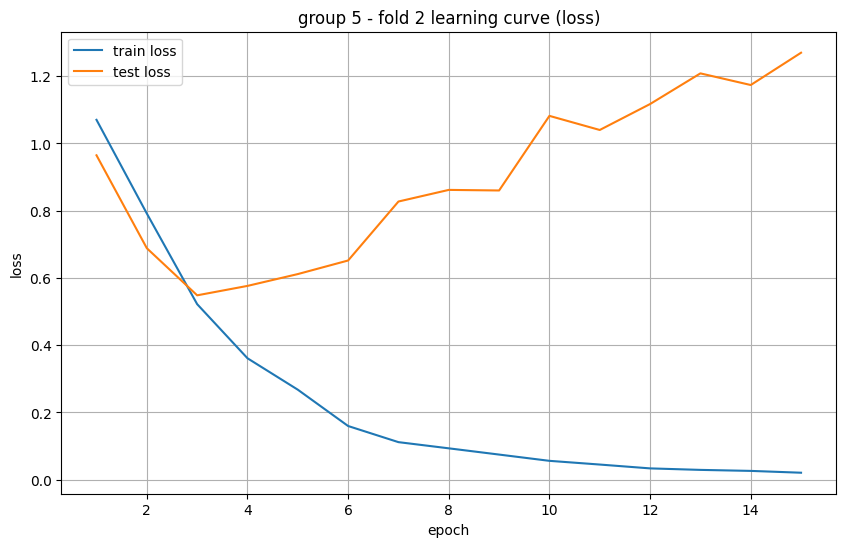

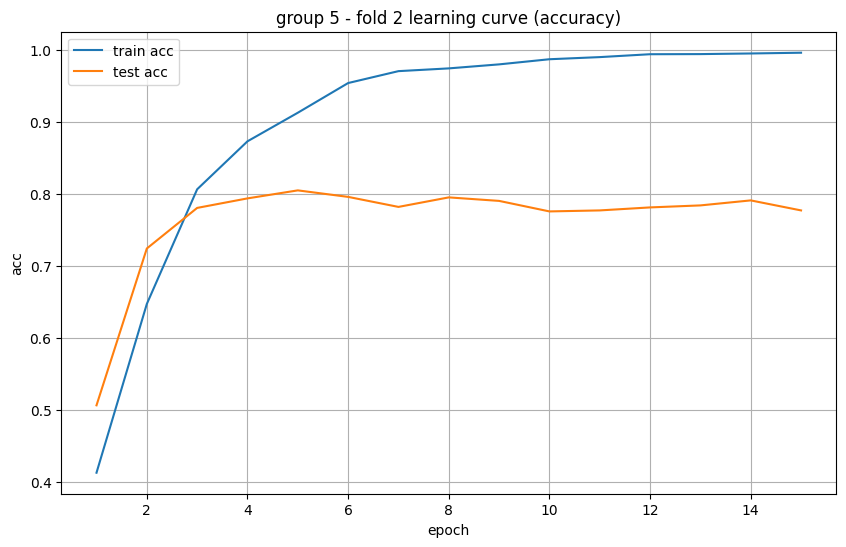

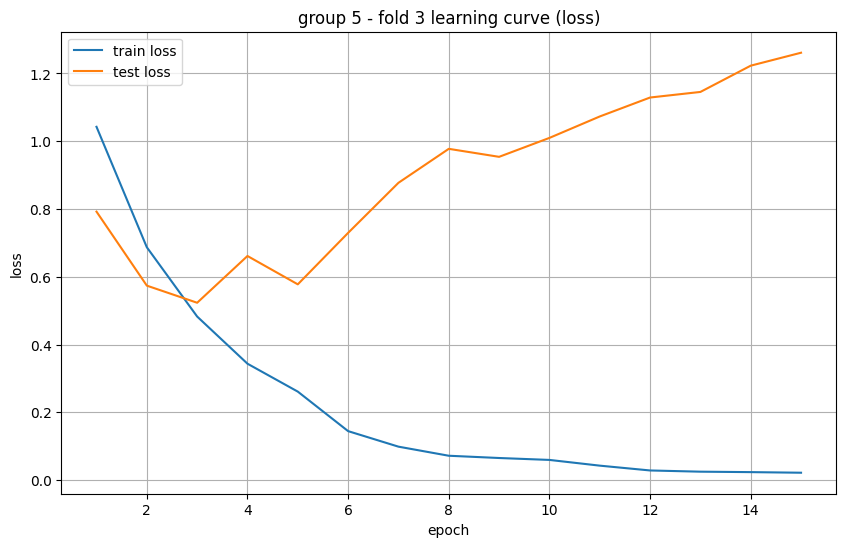

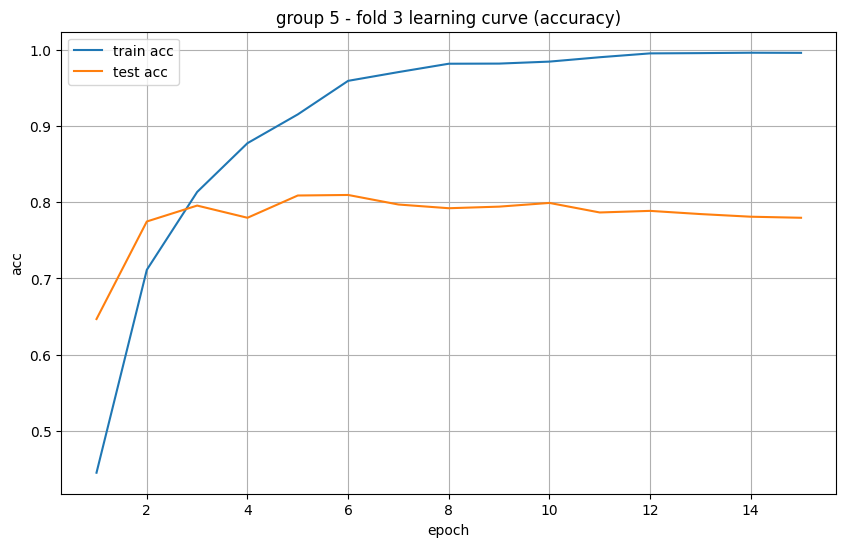

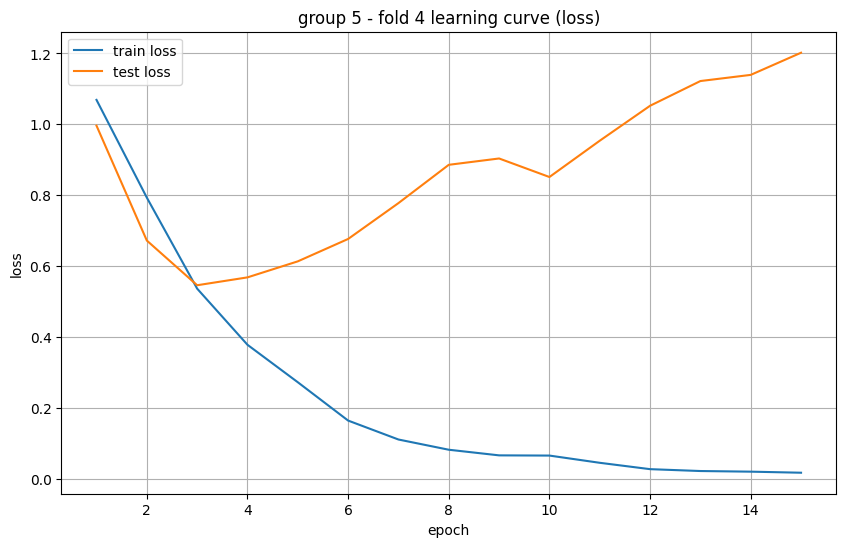

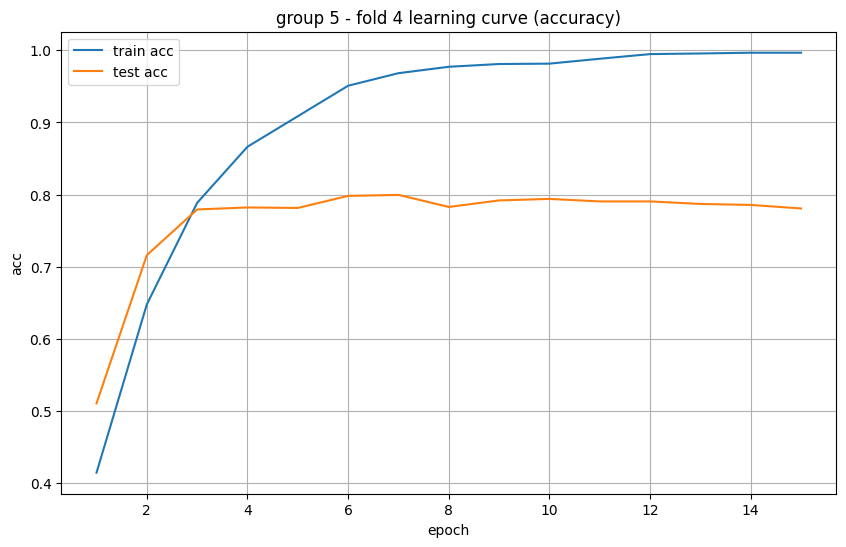

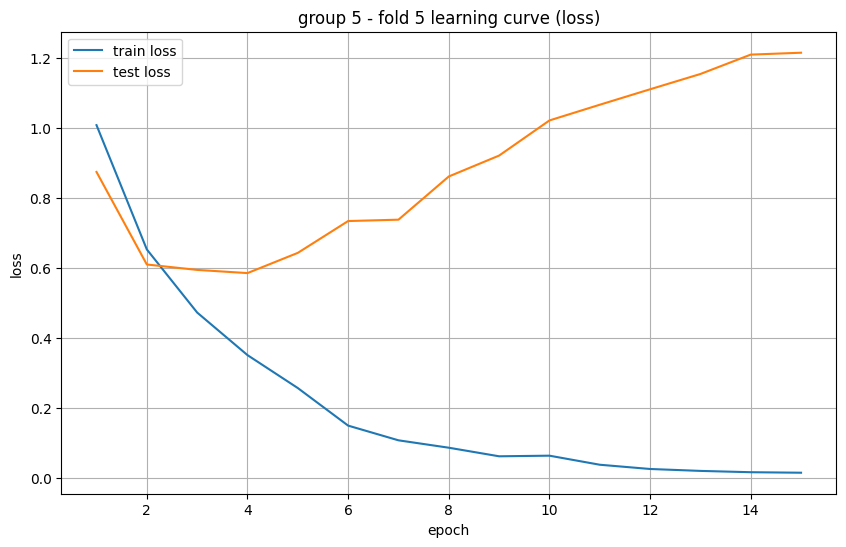

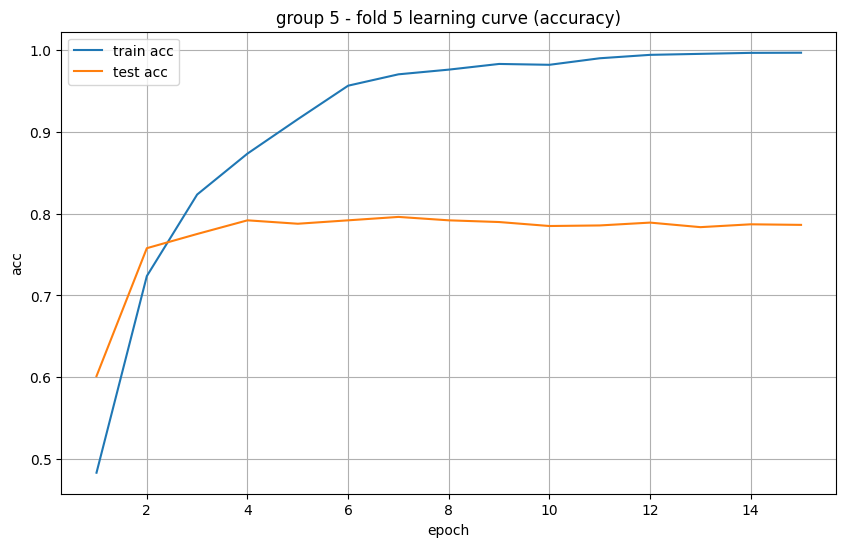

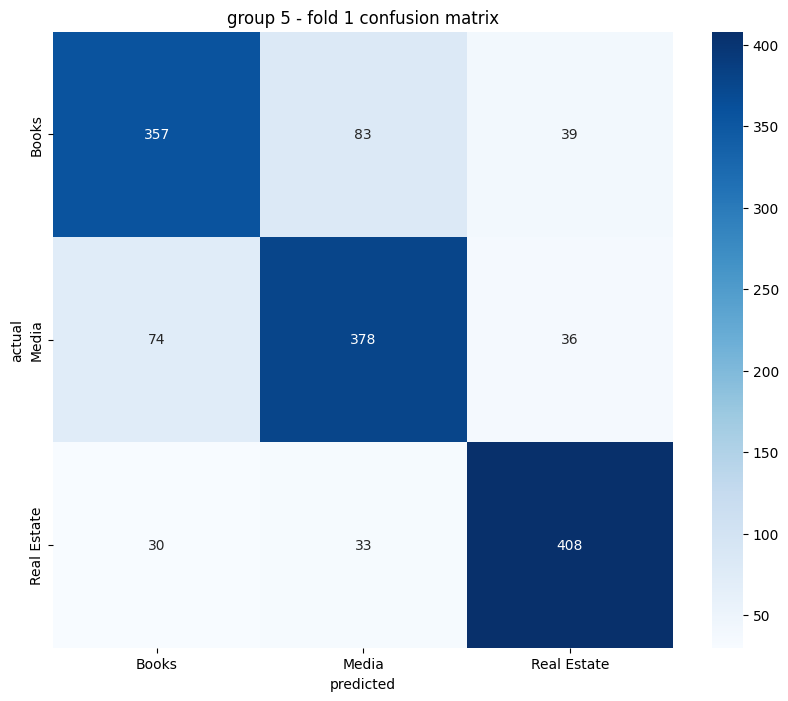

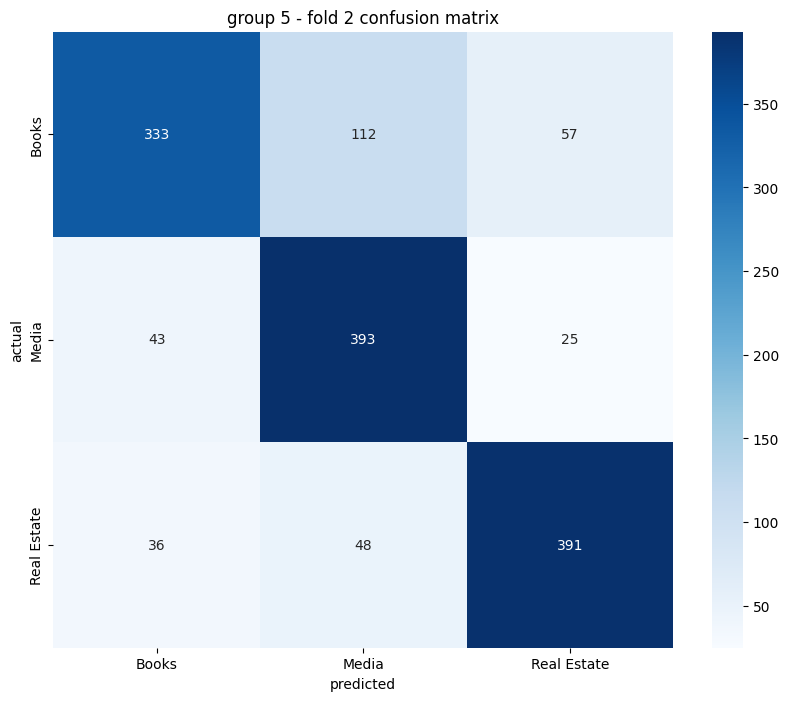

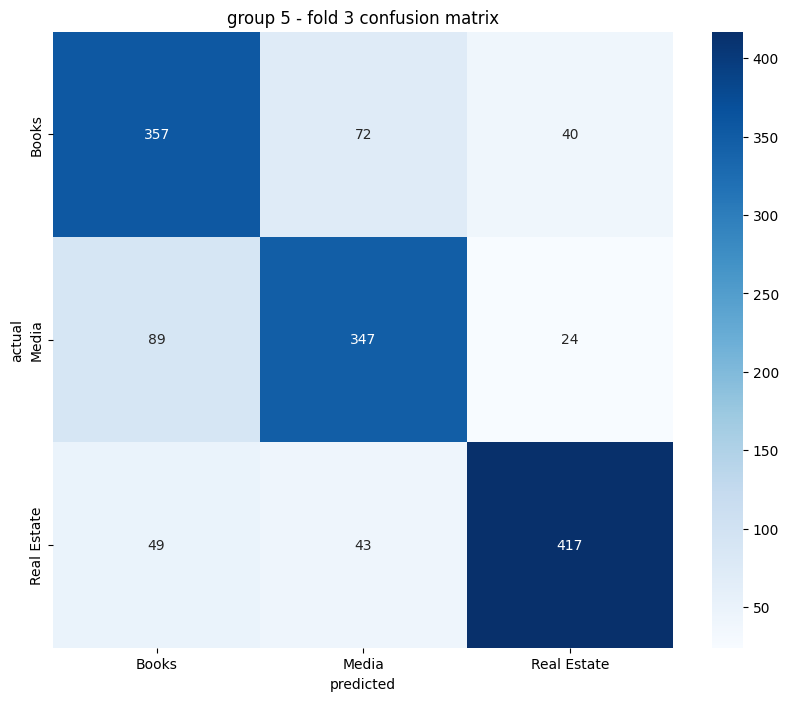

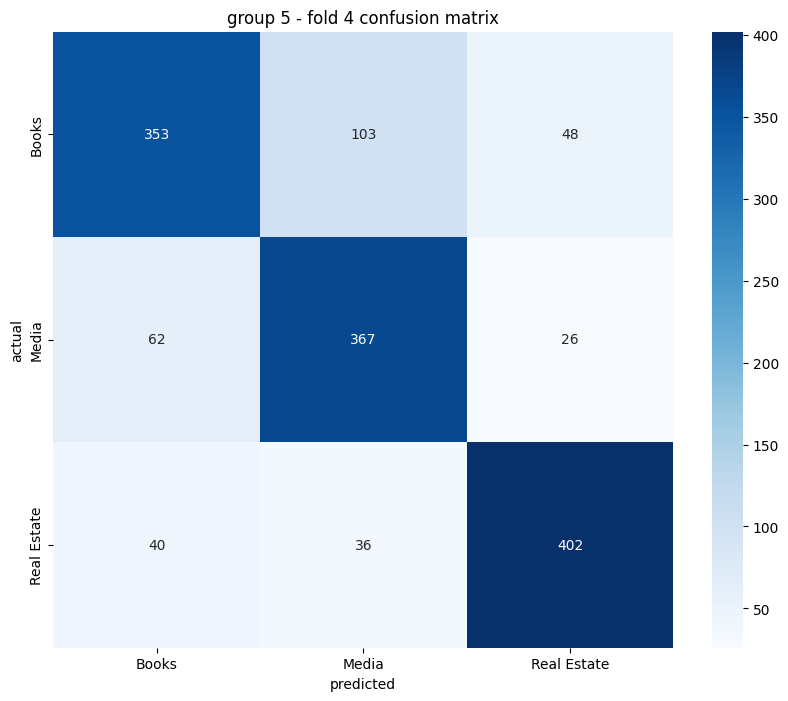

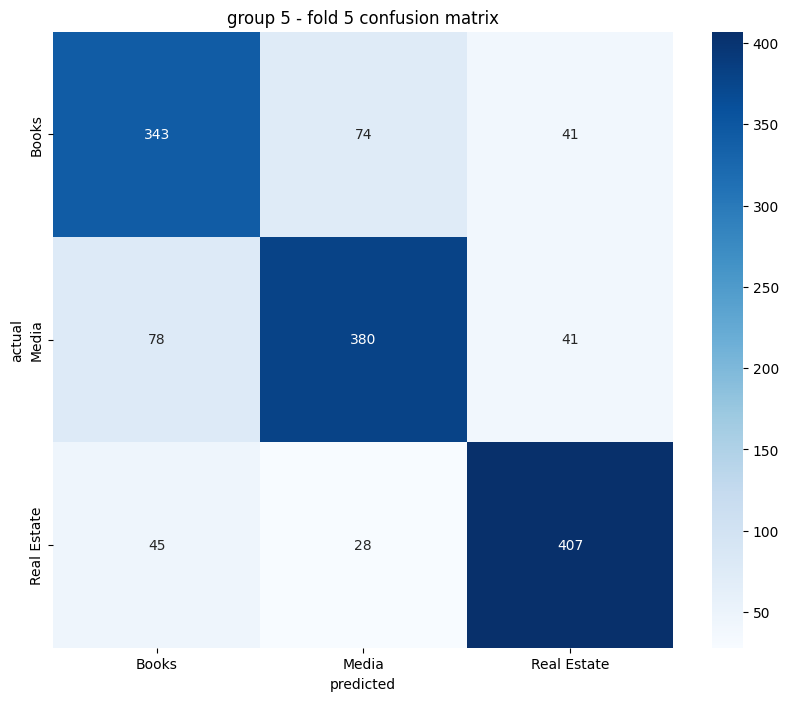


group 6 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.9510, train acc: 0.5278
                               test loss: 0.6872, test acc: 0.7396
    epoch 5/15: train loss: 0.1397, train acc: 0.9545
                               test loss: 0.3840, test acc: 0.8833
    epoch 10/15: train loss: 0.0207, train acc: 0.9957
                               test loss: 0.7135, test acc: 0.8639
    epoch 15/15: train loss: 0.0081, train acc: 0.9990
                               test loss: 0.6898, test acc: 0.8840

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.8678, train acc: 0.5953
                               test loss: 0.6358, test acc: 0.7715
    epoch 5/15: train loss: 0.2119, train acc: 0.9309
                               test loss: 0.3472, test acc: 0.8854
    epoch 10/15: train loss: 0.0381, train acc: 0.9896
                               test loss: 0.6218, test acc: 0.8694
    epoch 15/15: train loss: 0.0109, train acc: 0.9984
                               test lo

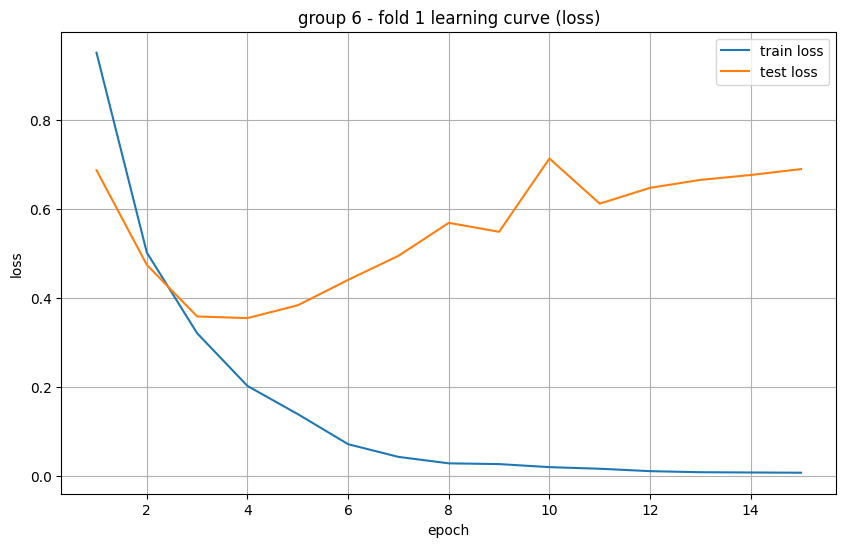

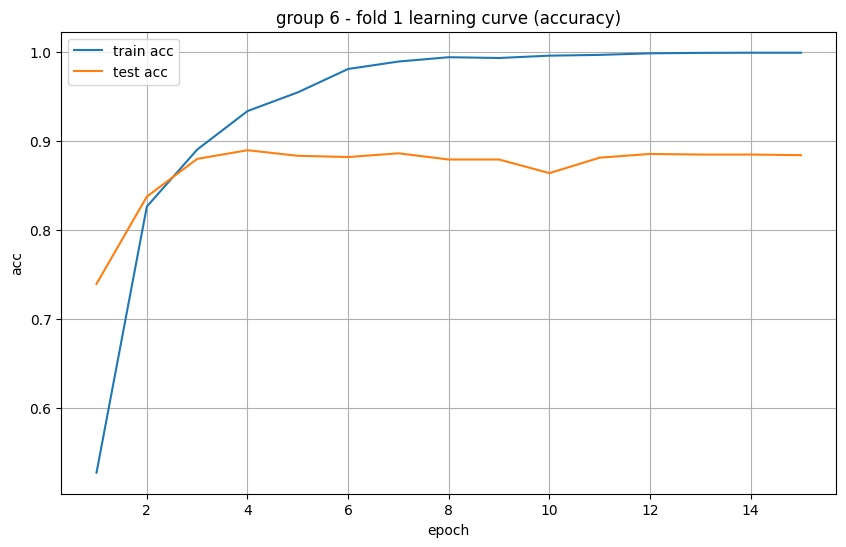

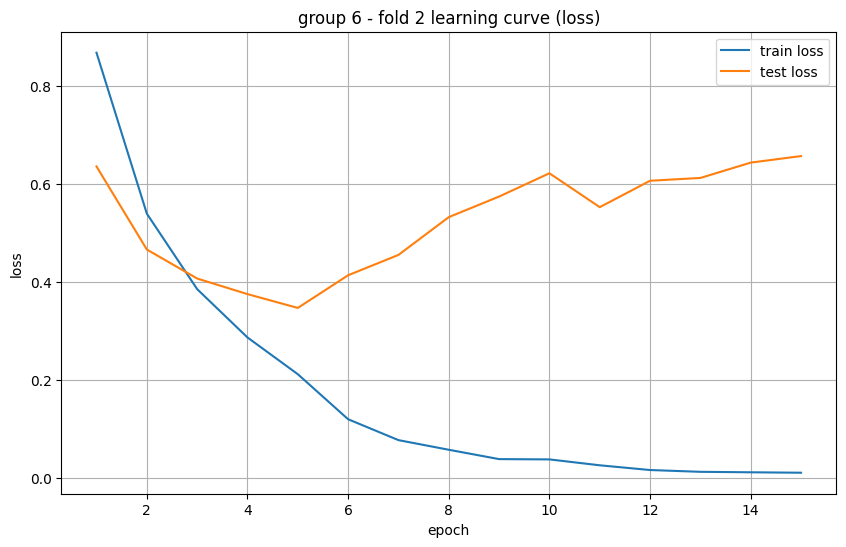

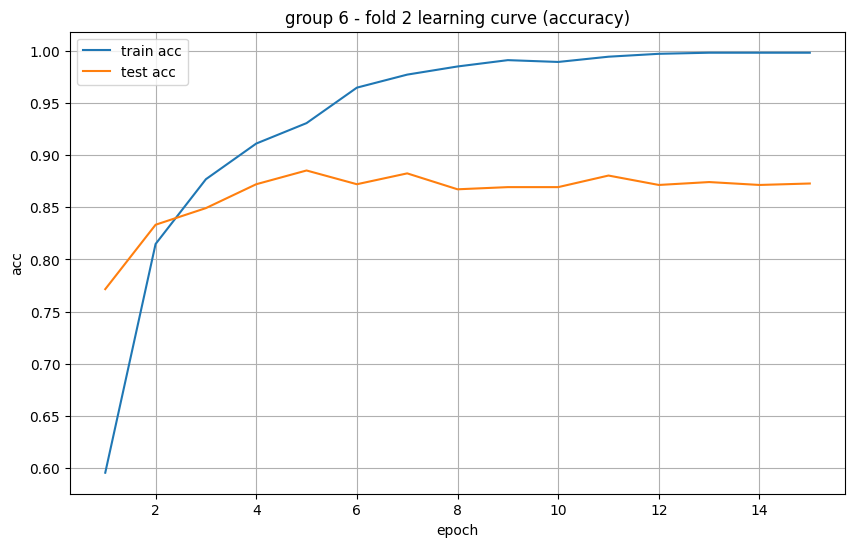

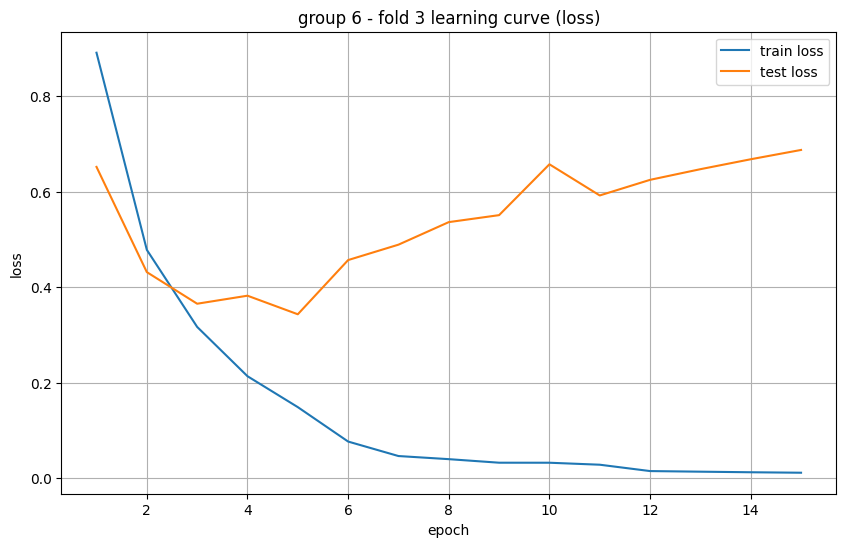

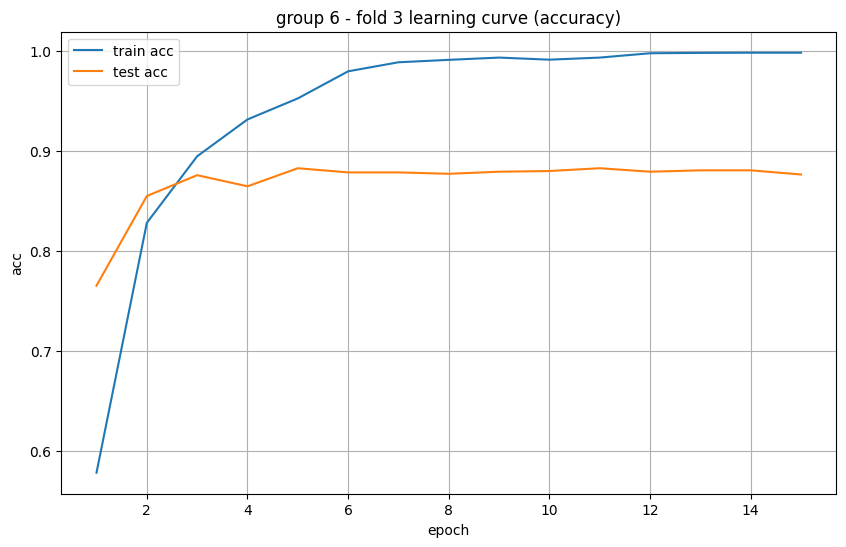

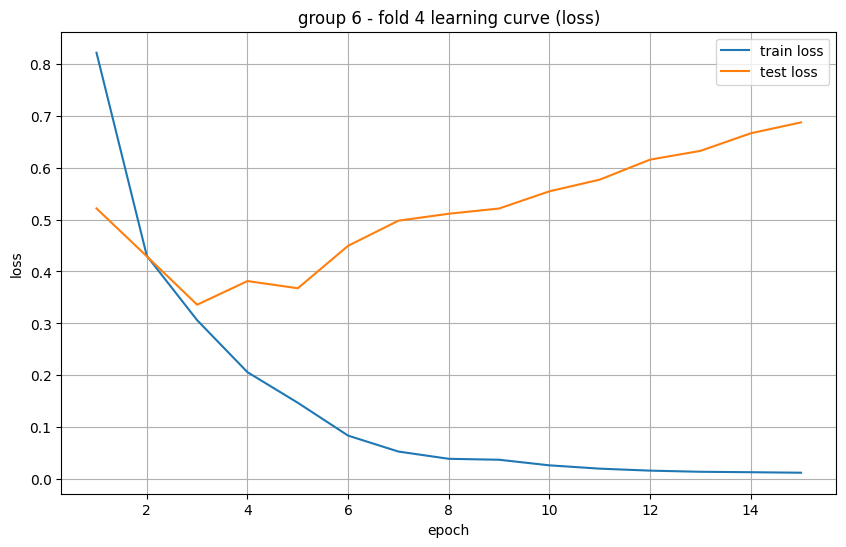

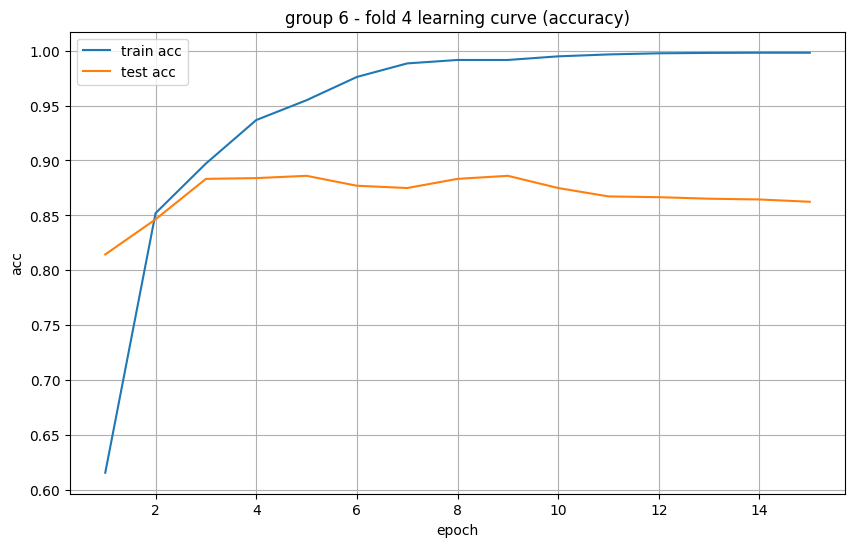

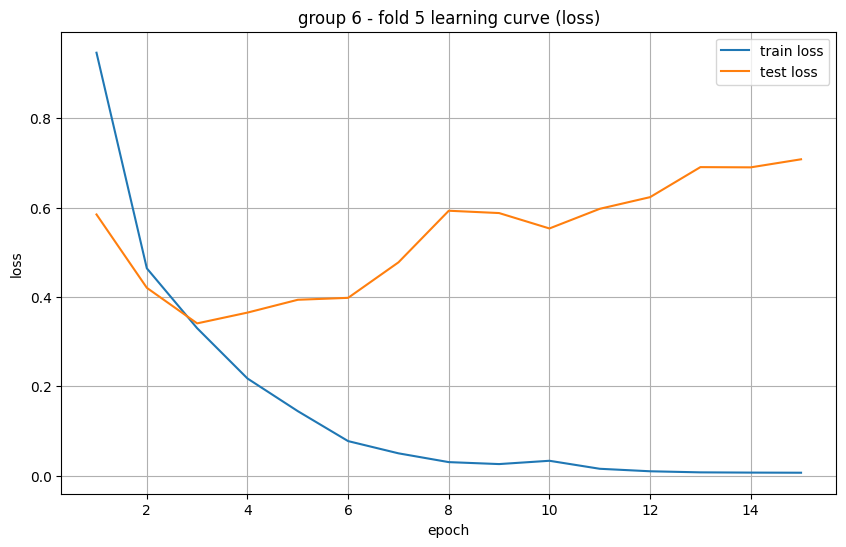

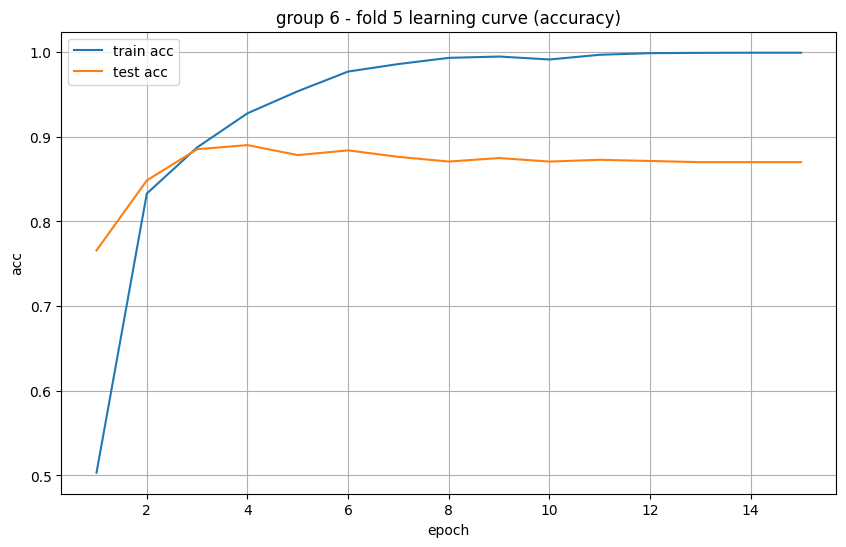

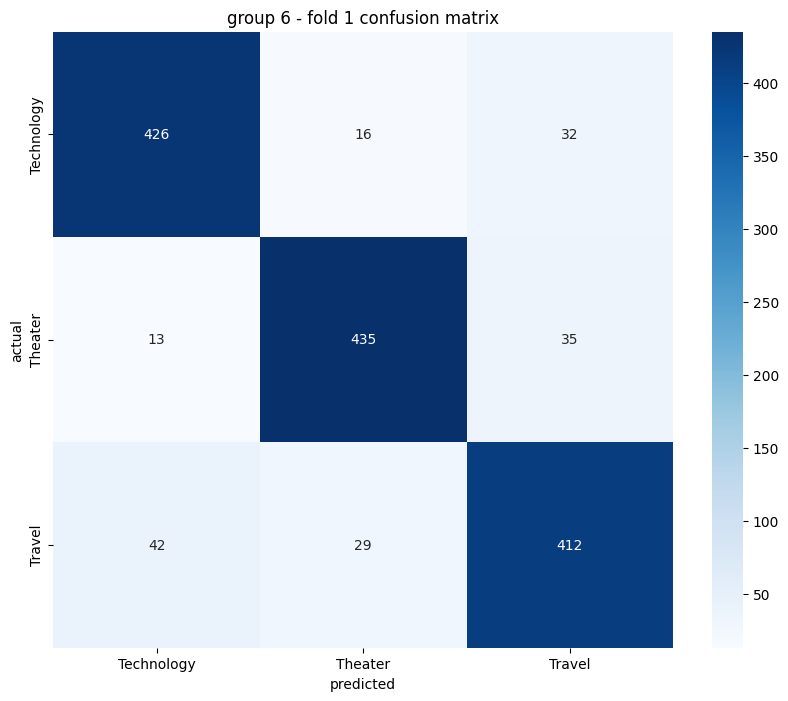

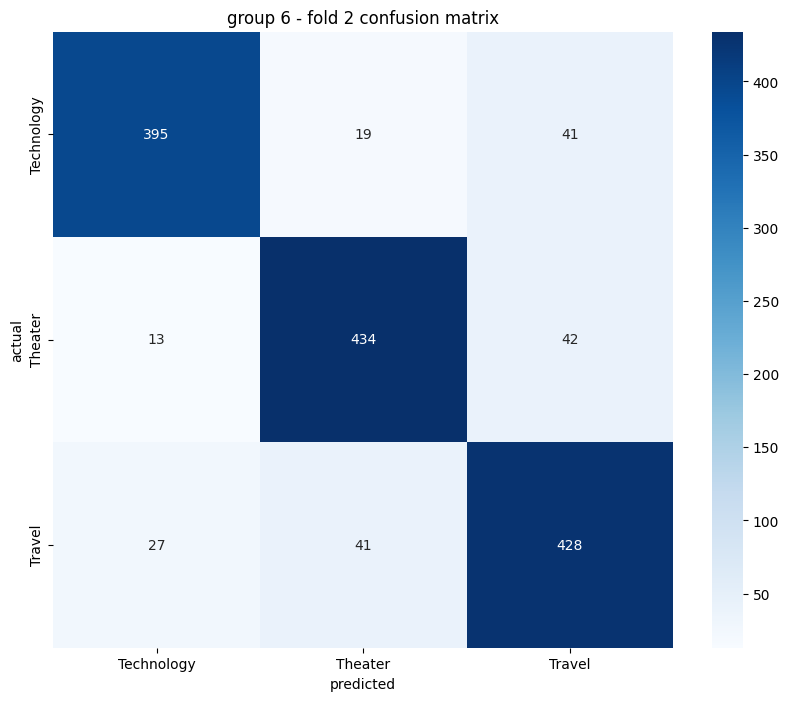

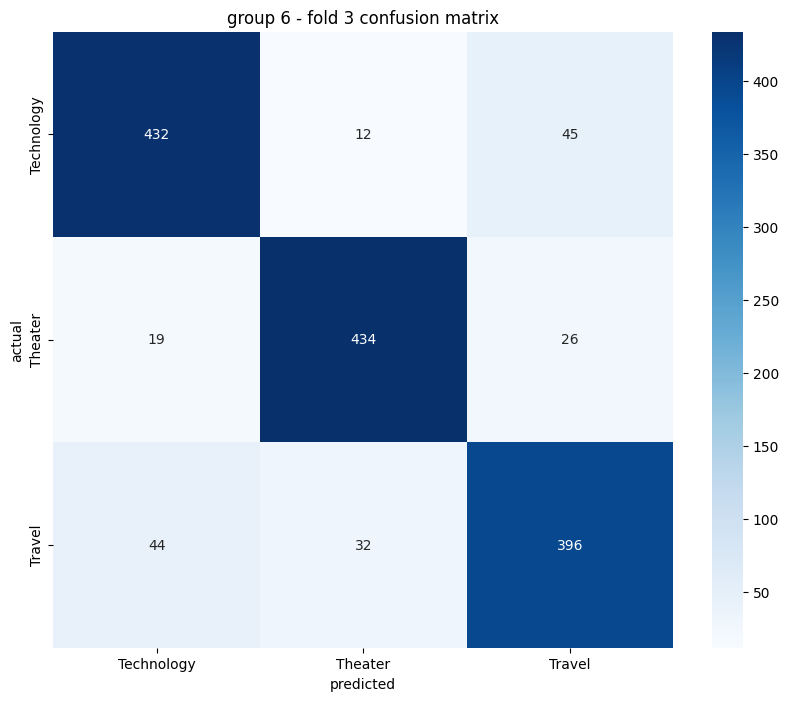

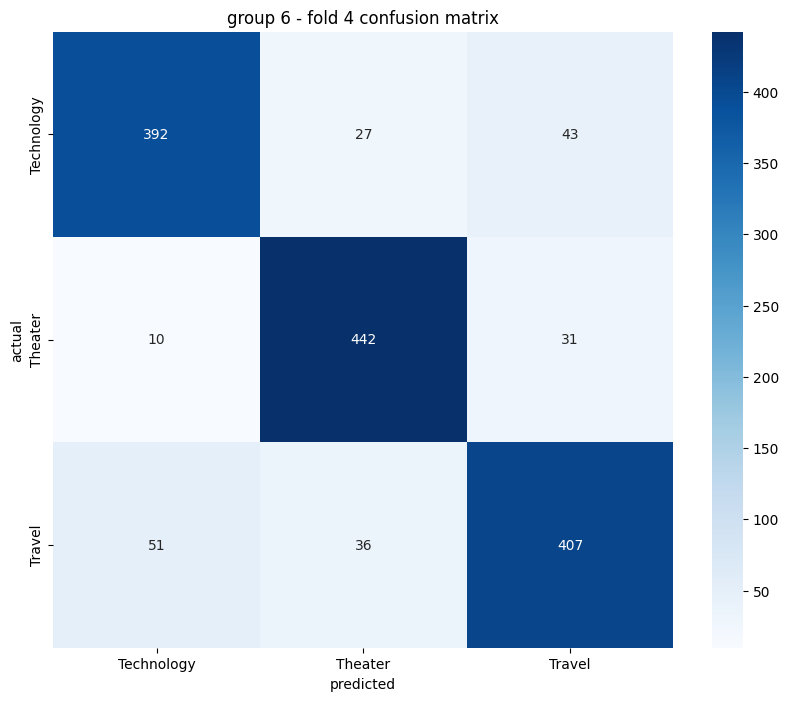

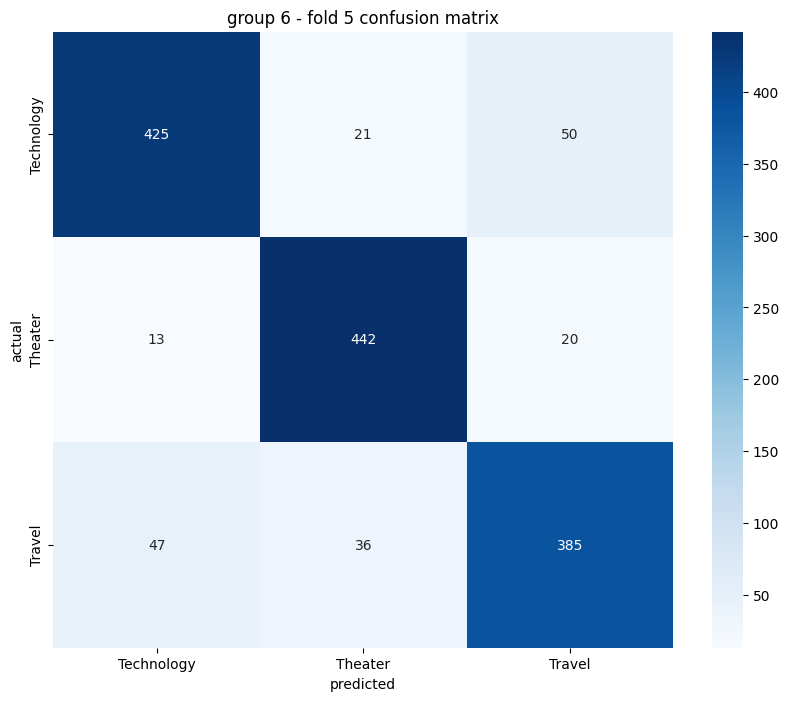


=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.8612
  폴드 1: 테스트 정확도 = 0.8578
  폴드 2: 테스트 정확도 = 0.8675
  폴드 3: 테스트 정확도 = 0.8661
  폴드 4: 테스트 정확도 = 0.8681
  폴드 5: 테스트 정확도 = 0.8466

그룹 2 - 평균 테스트 정확도: 0.7924
  폴드 1: 테스트 정확도 = 0.8043
  폴드 2: 테스트 정확도 = 0.7863
  폴드 3: 테스트 정확도 = 0.7856
  폴드 4: 테스트 정확도 = 0.7854
  폴드 5: 테스트 정확도 = 0.8007

그룹 3 - 평균 테스트 정확도: 0.8088
  폴드 1: 테스트 정확도 = 0.8165
  폴드 2: 테스트 정확도 = 0.8222
  폴드 3: 테스트 정확도 = 0.8029
  폴드 4: 테스트 정확도 = 0.7927
  폴드 5: 테스트 정확도 = 0.8099

그룹 4 - 평균 테스트 정확도: 0.8680
  폴드 1: 테스트 정확도 = 0.8693
  폴드 2: 테스트 정확도 = 0.8860
  폴드 3: 테스트 정확도 = 0.8574
  폴드 4: 테스트 정확도 = 0.8644
  폴드 5: 테스트 정확도 = 0.8630

그룹 5 - 평균 테스트 정확도: 0.7837
  폴드 1: 테스트 정확도 = 0.7949
  폴드 2: 테스트 정확도 = 0.7768
  폴드 3: 테스트 정확도 = 0.7796
  폴드 4: 테스트 정확도 = 0.7808
  폴드 5: 테스트 정확도 = 0.7864

그룹 6 - 평균 테스트 정확도: 0.8732
  폴드 1: 테스트 정확도 = 0.8840
  폴드 2: 테스트 정확도 = 0.8729
  폴드 3: 테스트 정확도 = 0.8764
  폴드 4: 테스트 정확도 = 0.8624
  폴드 5: 테스트 정확도 = 0.8700


In [3]:
EPOCHS = 15
BATCH_SIZE = 32
K_FOLDS = 5
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수

all_learning_curves = []

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })

   
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")